This script reproduces the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) by the HDDM (0.9.0) in this docker image.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print("HDDM's version is: ", hddm.__version__)
print("kabuki's version is: ", kabuki.__version__)

HDDM's version is:  0.8.0
kabuki's version is:  0.6.5


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.8/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


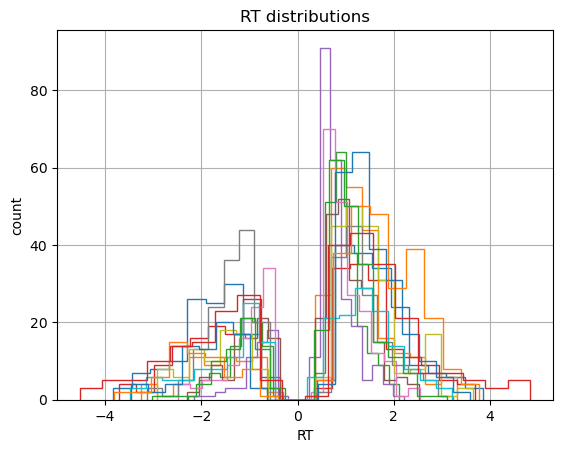

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [7]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

In [8]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m1 = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m1.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m1.sample(2000, burn=500)

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------100%-----------------] 2000 of 2000 complete in 35.3 sec

In [9]:
stats = m1.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.972238,0.094974,1.789256,1.908766,1.967491,2.030817,2.175885,0.002855
a_std,0.339278,0.079344,0.220872,0.284025,0.327605,0.380481,0.533786,0.002632
a_subj.0,2.196241,0.065208,2.071593,2.154291,2.19673,2.240766,2.320864,0.002308
a_subj.1,2.116275,0.065477,1.990808,2.07238,2.115996,2.156179,2.248005,0.002339


Plotting a
Plotting a_std
Plotting v
Plotting t


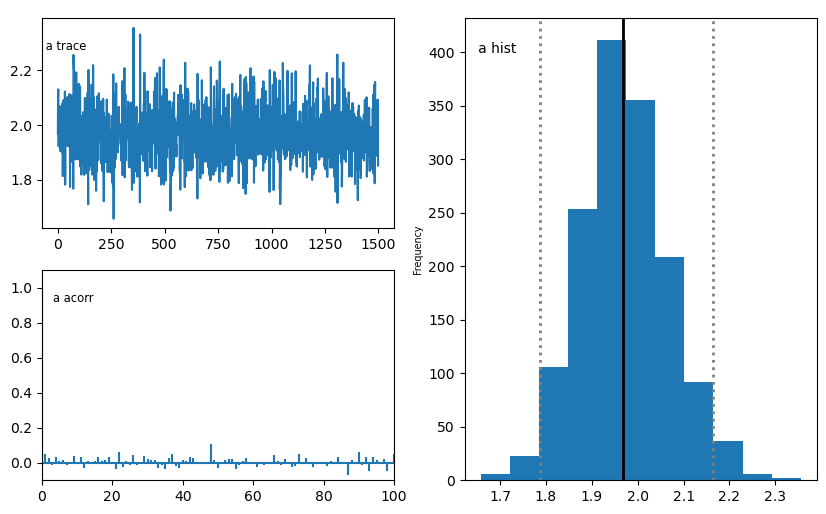

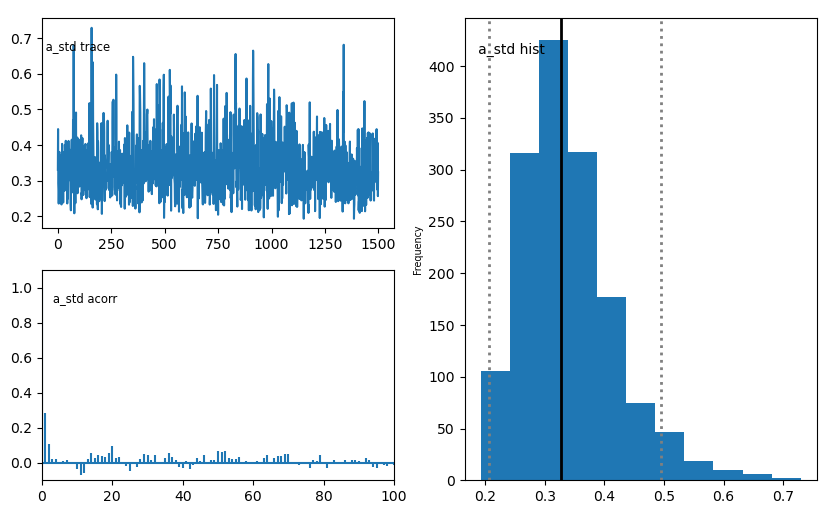

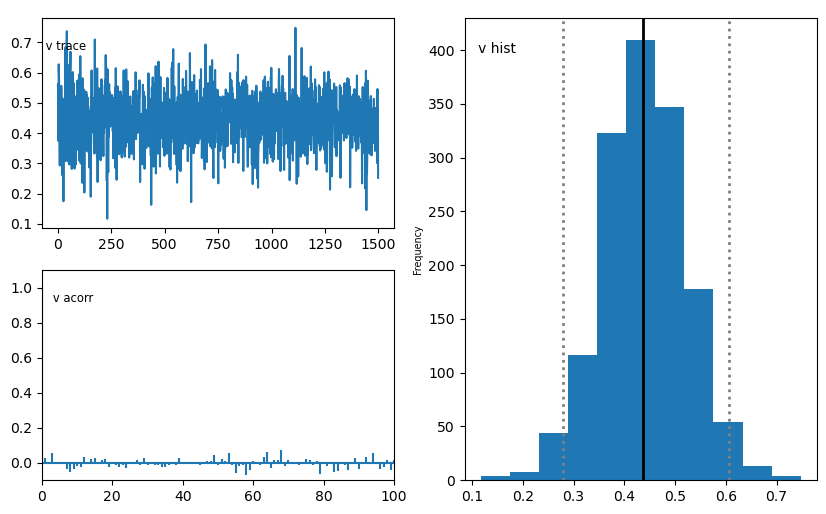

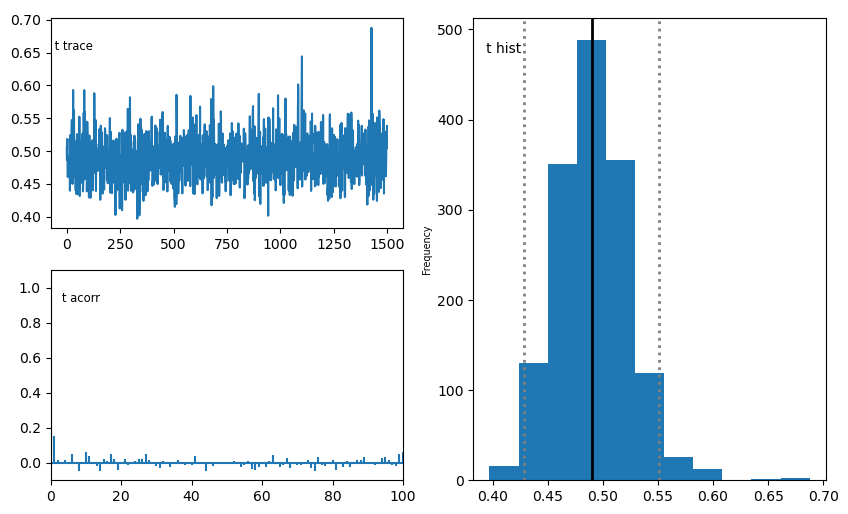

In [10]:
m1.plot_posteriors(['a', 't', 'v', 'a_std'])

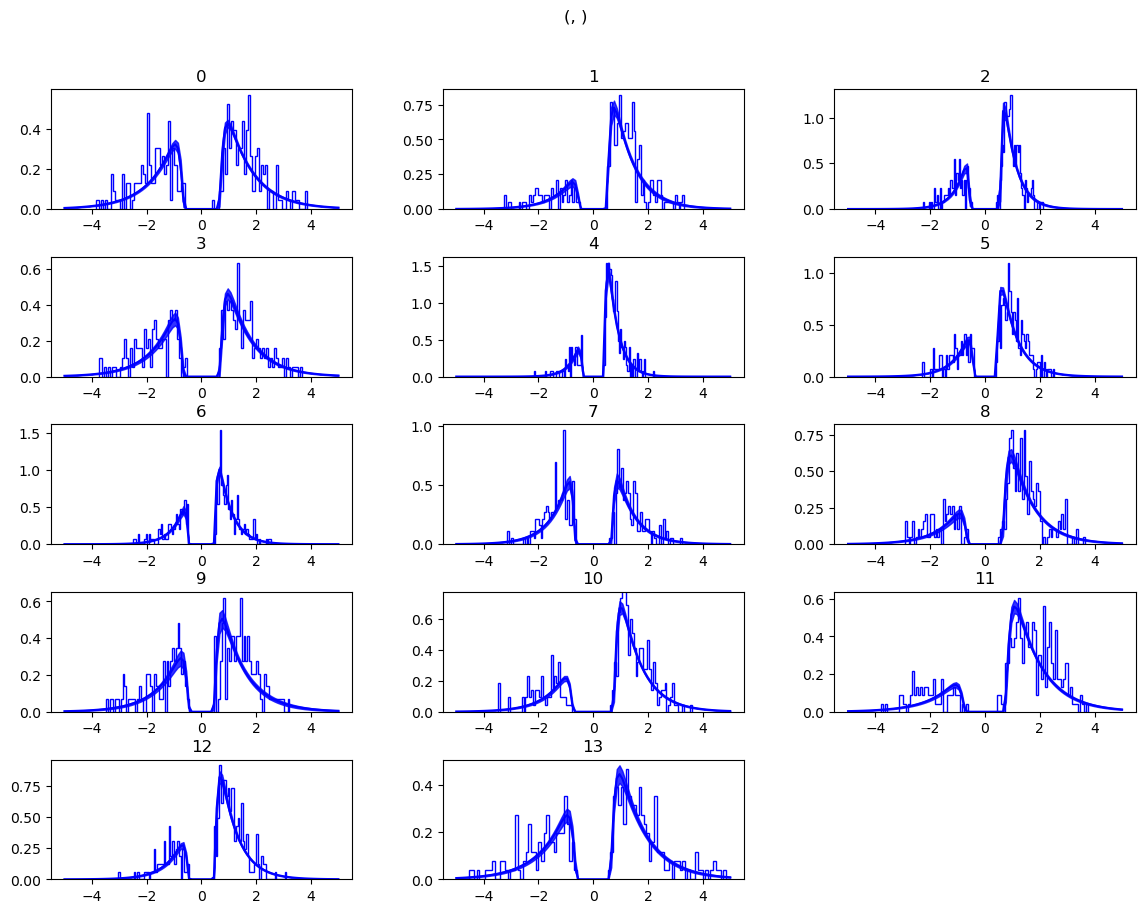

In [11]:
m1.plot_posterior_predictive(figsize=(14, 10))

## Calculate Gelman_rubin r hat.

The original tutorial used `for` loop:

In [12]:
# models = []
# for i in range(5):
#     m = hddm.HDDM(data)
#     m.find_starting_values()
#     m.sample(5000, burn=20)
#     models.append(m)

# hddm.analyze.gelman_rubin(models)

Here, we replace the `for` loop with parallel processing:

In [13]:
# parallel processing related packages
from p_tqdm import p_map
from functools import partial

In [14]:
def ms1(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m1"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [15]:
samples = 5000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 1000    
thin = 1
chains = 4

In [16]:
models_1 = p_map(partial(ms1, data=data, samples=samples, burn=burn),
                 range(chains)) # progess bar is a mess ;(

running model0
running model1


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


running model2


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


running model3

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 --                7%                  ] 388 of 5000 complete in 10.2 sec                 0%                  ] 21 of 5000 complete in 0.5 sec [                  0%                  ] 21 of 5000 complete in 0.5 sec[                  0%                  ] 21 of 5000 complete in 0.5 sec[                  0%                  ] 42 of 5000 complete in 1.0 sec [                  0%                  ] 41 of 5000 complete in 1.0 sec [                  0%                  ] 40 of 5000 complete in 1.0 sec[                  0%                  ] 41 of 5000 complete in 1.0 sec[                  1%                  ] 61 of 5000 complete in 1.5 sec[                  1%                  ] 59 of 5000 complete in 1.5 sec[                  1%                  ] 61 of 5000 complete in 1.6 sec[                  1%                  ] 61 of 5000 complete in 1.5 sec[                  1%                  ] 79 of 5000 complete in 2.0 sec[                  1%                  ] 78 of 5000 complete in 2.1 sec[  

 ----             11%                  ] 590 of 5000 complete in 16.0 secc[----             11%                  ] 574 of 5000 complete in 15.4 sec[----             11%                  ] 575 of 5000 complete in 15.4 sec[----             11%                  ] 571 of 5000 complete in 15.4 sec[----             11%                  ] 574 of 5000 complete in 15.4 sec[----             11%                  ] 593 of 5000 complete in 15.9 sec[----             11%                  ] 594 of 5000 complete in 15.9 sec [----             11%                  ] 593 of 5000 complete in 15.9 sec[----             12%                  ] 610 of 5000 complete in 16.4 sec[----             12%                  ] 611 of 5000 complete in 16.5 sec[----             12%                  ] 607 of 5000 complete in 16.5 sec[----             12%                  ] 611 of 5000 complete in 16.4 sec[----             12%                  ] 629 of 5000 complete in 16.9 sec[----             12%                  ] 630 of 5

 -----------      30%                  ] 1536 of 5000 complete in 42.2 secc  [--------         21%                  ] 1094 of 5000 complete in 29.9 sec[--------         21%                  ] 1097 of 5000 complete in 30.0 sec[--------         21%                  ] 1091 of 5000 complete in 30.1 sec[--------         22%                  ] 1107 of 5000 complete in 30.2 sec[--------         22%                  ] 1116 of 5000 complete in 30.5 sec[--------         22%                  ] 1114 of 5000 complete in 30.4 sec[--------         22%                  ] 1110 of 5000 complete in 30.6 sec[--------         22%                  ] 1126 of 5000 complete in 30.7 sec [--------         22%                  ] 1136 of 5000 complete in 31.0 sec[--------         22%                  ] 1130 of 5000 complete in 31.1 sec[--------         22%                  ] 1144 of 5000 complete in 31.2 sec[--------         22%                  ] 1149 of 5000 complete in 31.5 sec[--------         23%             

 ---------------  40%                  ] 2031 of 5000 complete in 58.3 secc[------------     32%                  ] 1610 of 5000 complete in 44.9 sec[------------     32%                  ] 1622 of 5000 complete in 45.0 sec[------------     32%                  ] 1630 of 5000 complete in 45.1 sec[------------     32%                  ] 1627 of 5000 complete in 45.3 sec[------------     32%                  ] 1624 of 5000 complete in 45.4 sec[------------     32%                  ] 1635 of 5000 complete in 45.5 sec[------------     32%                  ] 1643 of 5000 complete in 45.6 sec[------------     32%                  ] 1643 of 5000 complete in 45.8 sec[------------     32%                  ] 1641 of 5000 complete in 45.9 sec[------------     33%                  ] 1653 of 5000 complete in 46.0 sec[------------     33%                  ] 1661 of 5000 complete in 46.2 sec[------------     33%                  ] 1659 of 5000 complete in 46.3 sec[------------     33%                

 [---------------  41%                  ] 2063 of 5000 complete in 59.4 sec[---------------  41%                  ] 2070 of 5000 complete in 59.5 sec[---------------  41%                  ] 2082 of 5000 complete in 59.7 sec[---------------  41%                  ] 2075 of 5000 complete in 59.8 sec[---------------  41%                  ] 2076 of 5000 complete in 59.9 sec[---------------  41%                  ] 2083 of 5000 complete in 60.0 sec[---------------  41%                  ] 2098 of 5000 complete in 60.2 sec[---------------  41%                  ] 2091 of 5000 complete in 60.3 sec[---------------  41%                  ] 2092 of 5000 complete in 60.4 sec[---------------  41%                  ] 2099 of 5000 complete in 60.6 sec[---------------- 42%                  ] 2114 of 5000 complete in 60.7 sec[---------------- 42%                  ] 2107 of 5000 complete in 60.8 sec[---------------- 42%                  ] 2111 of 5000 complete in 61.1 sec[---------------- 42%                

 -----------------57%-                 ] 2858 of 5000 complete in 85.0 secc[-----------------50%                  ] 2515 of 5000 complete in 74.0 sec[-----------------50%                  ] 2515 of 5000 complete in 74.1 sec[-----------------50%                  ] 2534 of 5000 complete in 74.1 sec[-----------------50%                  ] 2522 of 5000 complete in 74.2 sec[-----------------50%                  ] 2531 of 5000 complete in 74.5 sec[-----------------50%                  ] 2532 of 5000 complete in 74.6 sec[-----------------51%                  ] 2550 of 5000 complete in 74.7 sec[-----------------50%                  ] 2540 of 5000 complete in 74.7 sec[-----------------51%                  ] 2550 of 5000 complete in 75.0 sec[-----------------51%                  ] 2550 of 5000 complete in 75.1 sec[-----------------51%                  ] 2569 of 5000 complete in 75.2 sec[-----------------51%                  ] 2559 of 5000 complete in 75.2 sec[-----------------51%                

 -----------------69%------            ] 3483 of 5000 complete in 101.9 sec[-----------------59%--                ] 2982 of 5000 complete in 88.5 sec[-----------------59%--                ] 2984 of 5000 complete in 88.6 sec[-----------------60%--                ] 3001 of 5000 complete in 88.6 sec[-----------------59%--                ] 2993 of 5000 complete in 88.8 sec[-----------------60%--                ] 3001 of 5000 complete in 89.0 sec[-----------------60%--                ] 3004 of 5000 complete in 89.1 sec[-----------------60%--                ] 3020 of 5000 complete in 89.2 sec[-----------------60%--                ] 3013 of 5000 complete in 89.3 sec[-----------------60%--                ] 3020 of 5000 complete in 89.6 sec[-----------------60%--                ] 3024 of 5000 complete in 89.6 sec[-----------------60%---               ] 3039 of 5000 complete in 89.7 sec[-----------------60%---               ] 3031 of 5000 complete in 89.8 sec[-----------------60%---             

 [-----------------70%------            ] 3518 of 5000 complete in 103.0 sec[-----------------70%------            ] 3522 of 5000 complete in 103.0 sec[-----------------70%------            ] 3539 of 5000 complete in 103.0 sec[-----------------70%------            ] 3524 of 5000 complete in 103.1 sec[-----------------70%------            ] 3537 of 5000 complete in 103.5 sec[-----------------70%------            ] 3542 of 5000 complete in 103.5 sec[-----------------71%-------           ] 3559 of 5000 complete in 103.6 sec[-----------------70%------            ] 3543 of 5000 complete in 103.6 sec[-----------------71%-------           ] 3556 of 5000 complete in 104.0 sec[-----------------71%-------           ] 3562 of 5000 complete in 104.0 sec[-----------------71%-------           ] 3578 of 5000 complete in 104.1 sec[-----------------71%-------           ] 3562 of 5000 complete in 104.1 sec[-----------------71%-------           ] 3574 of 5000 complete in 104.5 sec[-----------------71%---

 -----------------87%-------------     ] 4364 of 5000 complete in 125.0 secc[-----------------80%----------        ] 4046 of 5000 complete in 117.0 sec[-----------------81%----------        ] 4062 of 5000 complete in 117.3 sec[-----------------81%----------        ] 4070 of 5000 complete in 117.4 sec[-----------------81%-----------       ] 4087 of 5000 complete in 117.5 sec[-----------------81%----------        ] 4066 of 5000 complete in 117.5 sec[-----------------81%-----------       ] 4081 of 5000 complete in 117.9 sec[-----------------81%-----------       ] 4090 of 5000 complete in 117.9 sec[-----------------82%-----------       ] 4106 of 5000 complete in 118.0 sec[-----------------81%-----------       ] 4086 of 5000 complete in 118.0 sec[-----------------82%-----------       ] 4101 of 5000 complete in 118.4 sec[-----------------82%-----------       ] 4110 of 5000 complete in 118.4 sec[-----------------82%-----------       ] 4126 of 5000 complete in 118.5 sec[-----------------82%---

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 -----------------100%-----------------] 5000 of 5000 complete in 141.7 sec [-----------------99%----------------- ] 4984 of 5000 complete in 141.7 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 -----------------100%-----------------] 5000 of 5000 complete in 142.0 sec[-----------------100%-----------------] 5000 of 5000 complete in 142.1 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

In [17]:
hddm.analyze.gelman_rubin(models_1)

{'a': 1.0000365487798624,
 'a_std': 1.0001624301616465,
 'a_subj.0': 1.000018863177355,
 'a_subj.1': 1.0005715017415258,
 'a_subj.2': 1.0004497170249573,
 'a_subj.3': 1.000105958437465,
 'a_subj.4': 1.0005981687098198,
 'a_subj.5': 1.0008584179261766,
 'a_subj.6': 1.0000538272844681,
 'a_subj.7': 1.0002424167569859,
 'a_subj.8': 1.0000820853091705,
 'a_subj.9': 0.9999182884817811,
 'a_subj.10': 1.0002284480534716,
 'a_subj.11': 0.9999267212603195,
 'a_subj.12': 1.0000766911873404,
 'a_subj.13': 1.0000850260524587,
 'v': 0.9999298104831266,
 'v_std': 1.0001921750709986,
 'v_subj.0': 1.000366952636063,
 'v_subj.1': 0.9998973977240065,
 'v_subj.2': 1.000374807412652,
 'v_subj.3': 1.0000812335377474,
 'v_subj.4': 1.0002264362048847,
 'v_subj.5': 0.9999133446969628,
 'v_subj.6': 1.0001149860869936,
 'v_subj.7': 0.9999166711118415,
 'v_subj.8': 1.0000739935698408,
 'v_subj.9': 1.000066123702378,
 'v_subj.10': 0.9999604054215326,
 'v_subj.11': 1.0000083031492173,
 'v_subj.12': 1.0004563060695

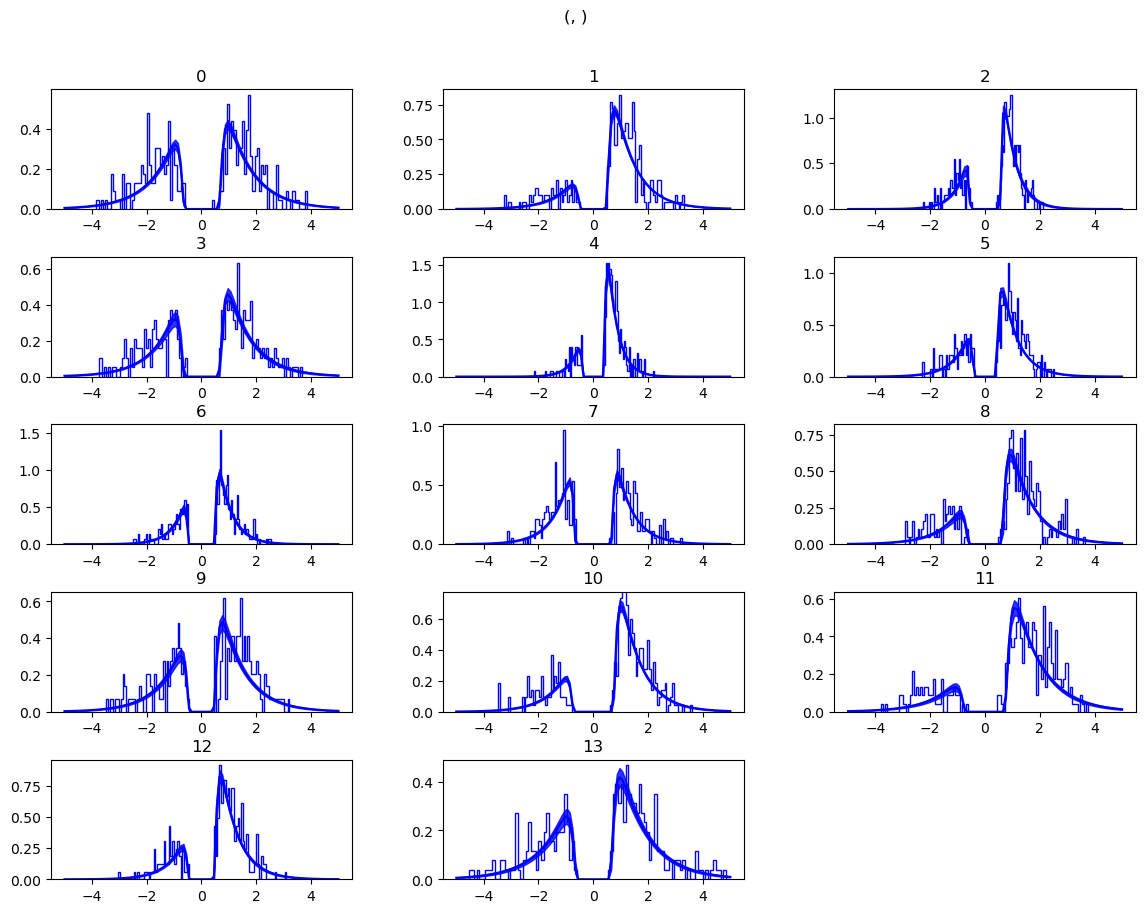

In [18]:
models_1[0].plot_posterior_predictive(figsize=(14, 10))

In [19]:
m_comb = kabuki.utils.concat_models(models_1) # combine four chains together

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

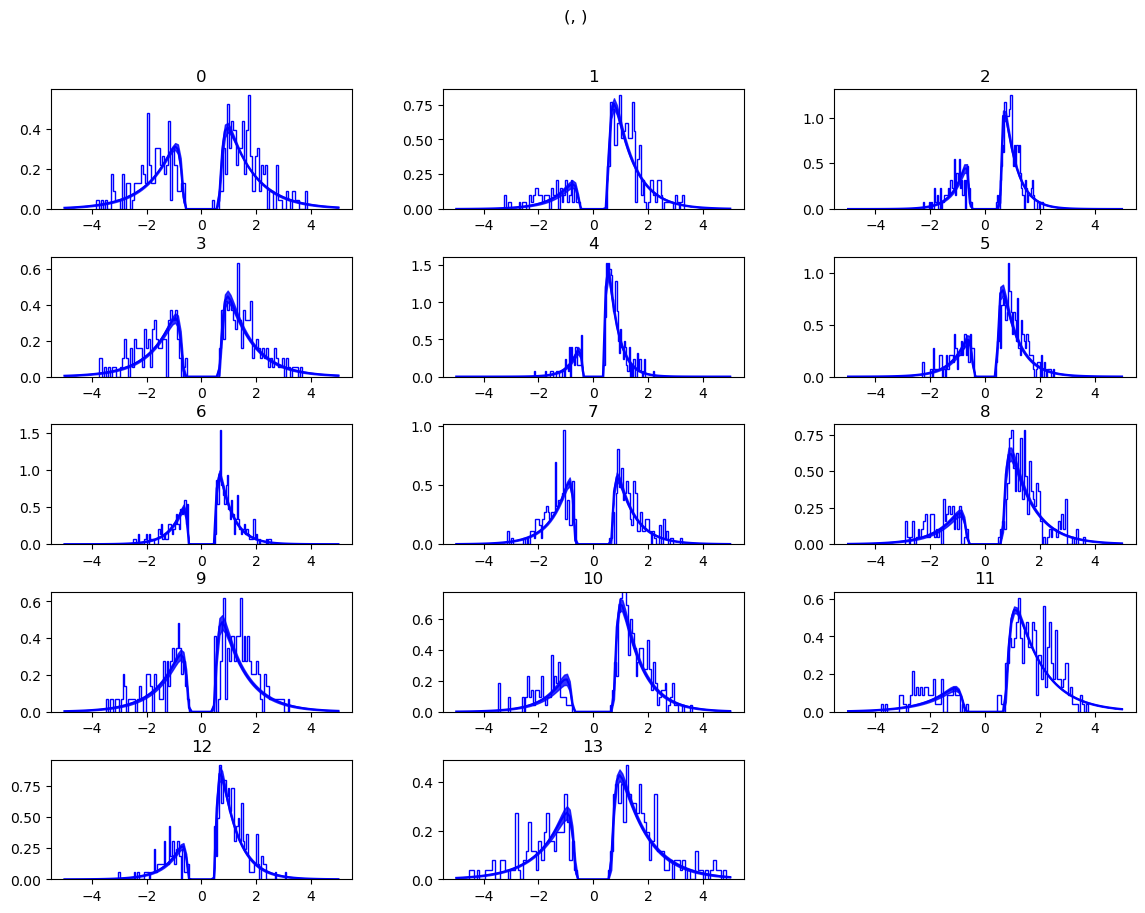

In [20]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

### Model 2: `v` depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [21]:
def ms2(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m2"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # save the model data
    m.save(mname)
    
    return m

In [22]:
# note: the samples, burn, and chains can be changed too
models_2 = p_map(partial(ms2, data=data, samples=samples, burn=burn),
                 range(chains))

  0%|          | 0/4 [00:00<?, ?it/s]

running model0
running model1
running model2

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])


running model3

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 -                 5%                  ] 250 of 5000 complete in 14.8 sec                  0%                  ] 11 of 5000 complete in 0.6 sec[                  0%                  ] 11 of 5000 complete in 0.6 sec[                  0%                  ] 10 of 5000 complete in 0.5 sec[                  0%                  ] 19 of 5000 complete in 1.0 sec[                  0%                  ] 20 of 5000 complete in 1.1 sec[                  0%                  ] 19 of 5000 complete in 1.0 sec[                  0%                  ] 21 of 5000 complete in 1.1 sec  [                  0%                  ] 30 of 5000 complete in 1.6 sec[                  0%                  ] 29 of 5000 complete in 1.6 sec[                  0%                  ] 29 of 5000 complete in 1.5 sec[                  0%                  ] 31 of 5000 complete in 1.6 sec[                  0%                  ] 40 of 5000 complete in 2.1 sec[                  0%                  ] 39 of 5000 complete in 2.1 sec[  

 [-                 5%                  ] 261 of 5000 complete in 15.5 sec[--                5%                  ] 270 of 5000 complete in 15.9 sec[--                5%                  ] 269 of 5000 complete in 15.9 sec[--                5%                  ] 268 of 5000 complete in 15.9 sec[--                5%                  ] 271 of 5000 complete in 16.1 sec[--                5%                  ] 280 of 5000 complete in 16.4 sec[--                5%                  ] 279 of 5000 complete in 16.4 sec[--                5%                  ] 278 of 5000 complete in 16.4 sec[--                5%                  ] 281 of 5000 complete in 16.6 sec[--                5%                  ] 290 of 5000 complete in 16.9 sec[--                5%                  ] 289 of 5000 complete in 17.0 sec[--                5%                  ] 288 of 5000 complete in 16.9 sec[--                5%                  ] 291 of 5000 complete in 17.1 sec[--                6%                  ] 300 of 50

 [------           15%                  ] 798 of 5000 complete in 45.7 sec[------           16%                  ] 805 of 5000 complete in 45.9 sec[------           16%                  ] 804 of 5000 complete in 46.1 sec[------           16%                  ] 805 of 5000 complete in 46.2 sec[------           16%                  ] 807 of 5000 complete in 46.3 sec[------           16%                  ] 813 of 5000 complete in 46.5 sec[------           16%                  ] 812 of 5000 complete in 46.6 sec[------           16%                  ] 813 of 5000 complete in 46.7 sec[------           16%                  ] 816 of 5000 complete in 46.9 sec[------           16%                  ] 822 of 5000 complete in 47.0 sec[------           16%                  ] 821 of 5000 complete in 47.1 sec[------           16%                  ] 822 of 5000 complete in 47.3 sec[------           16%                  ] 825 of 5000 complete in 47.4 sec[------           16%                  ] 830 of 50

 [--------         21%                  ] 1053 of 5000 complete in 60.7 sec[--------         21%                  ] 1056 of 5000 complete in 60.8 sec  [--------         21%                  ] 1056 of 5000 complete in 61.0 sec[--------         21%                  ] 1055 of 5000 complete in 61.0 sec[--------         21%                  ] 1061 of 5000 complete in 61.3 sec[--------         21%                  ] 1065 of 5000 complete in 61.4 sec[--------         21%                  ] 1064 of 5000 complete in 61.5 sec[--------         21%                  ] 1065 of 5000 complete in 61.6 sec[--------         21%                  ] 1070 of 5000 complete in 61.8 sec[--------         21%                  ] 1074 of 5000 complete in 61.9 sec[--------         21%                  ] 1073 of 5000 complete in 62.0 sec[--------         21%                  ] 1074 of 5000 complete in 62.1 sec[--------         21%                  ] 1080 of 5000 complete in 62.4 sec[--------         21%              

 [---------        25%                  ] 1296 of 5000 complete in 75.4 sec[---------        25%                  ] 1299 of 5000 complete in 75.5 sec[---------        26%                  ] 1302 of 5000 complete in 75.8 sec[---------        26%                  ] 1306 of 5000 complete in 75.7 sec[---------        26%                  ] 1304 of 5000 complete in 76.0 sec[---------        26%                  ] 1306 of 5000 complete in 76.0 sec[---------        26%                  ] 1310 of 5000 complete in 76.4 sec[---------        26%                  ] 1314 of 5000 complete in 76.3 sec[---------        26%                  ] 1312 of 5000 complete in 76.5 sec[---------        26%                  ] 1315 of 5000 complete in 76.6 sec[----------       26%                  ] 1319 of 5000 complete in 76.9 sec[----------       26%                  ] 1323 of 5000 complete in 76.8 sec[----------       26%                  ] 1322 of 5000 complete in 77.0 sec[----------       26%                

 ------------     32%                  ] 1622 of 5000 complete in 96.0 secc[-----------      30%                  ] 1537 of 5000 complete in 90.3 sec[-----------      30%                  ] 1539 of 5000 complete in 90.3 sec[-----------      30%                  ] 1542 of 5000 complete in 90.6 sec[-----------      30%                  ] 1547 of 5000 complete in 90.5 sec[-----------      30%                  ] 1546 of 5000 complete in 90.8 sec[-----------      30%                  ] 1548 of 5000 complete in 90.8 sec[-----------      31%                  ] 1550 of 5000 complete in 91.1 sec[-----------      31%                  ] 1555 of 5000 complete in 91.1 sec[-----------      31%                  ] 1557 of 5000 complete in 91.4 sec[-----------      31%                  ] 1555 of 5000 complete in 91.4 sec[-----------      31%                  ] 1559 of 5000 complete in 91.6 sec[-----------      31%                  ] 1564 of 5000 complete in 91.6 sec[-----------      31%                

 [-------------    35%                  ] 1780 of 5000 complete in 105.1 sec[-------------    35%                  ] 1783 of 5000 complete in 105.2 sec[-------------    35%                  ] 1784 of 5000 complete in 105.4 sec[-------------    35%                  ] 1792 of 5000 complete in 105.5 sec[-------------    35%                  ] 1790 of 5000 complete in 105.7 sec[-------------    35%                  ] 1793 of 5000 complete in 105.8 sec[-------------    35%                  ] 1794 of 5000 complete in 105.9 sec[-------------    36%                  ] 1802 of 5000 complete in 106.0 sec[-------------    36%                  ] 1800 of 5000 complete in 106.2 sec[-------------    36%                  ] 1802 of 5000 complete in 106.3 sec[-------------    36%                  ] 1804 of 5000 complete in 106.4 sec[-------------    36%                  ] 1812 of 5000 complete in 106.5 sec[-------------    36%                  ] 1810 of 5000 complete in 106.7 sec[-------------    36%   

 [---------------  41%                  ] 2053 of 5000 complete in 119.6 sec[---------------  41%                  ] 2061 of 5000 complete in 119.7 sec[---------------  41%                  ] 2060 of 5000 complete in 119.8 sec[---------------  41%                  ] 2063 of 5000 complete in 119.9 sec[---------------  41%                  ] 2063 of 5000 complete in 120.1 sec[---------------  41%                  ] 2071 of 5000 complete in 120.2 sec[---------------  41%                  ] 2070 of 5000 complete in 120.4 sec[---------------  41%                  ] 2072 of 5000 complete in 120.4 sec[---------------  41%                  ] 2073 of 5000 complete in 120.6 sec[---------------  41%                  ] 2081 of 5000 complete in 120.7 sec[---------------  41%                  ] 2080 of 5000 complete in 120.9 sec[---------------  41%                  ] 2082 of 5000 complete in 121.0 sec[---------------  41%                  ] 2083 of 5000 complete in 121.1 sec[---------------  41%   

 -----------------48%                  ] 2406 of 5000 complete in 138.1 secc[-----------------46%                  ] 2329 of 5000 complete in 134.1 sec[-----------------46%                  ] 2331 of 5000 complete in 134.5 sec[-----------------46%                  ] 2338 of 5000 complete in 134.4 sec[-----------------46%                  ] 2336 of 5000 complete in 134.6 sec[-----------------46%                  ] 2339 of 5000 complete in 134.7 sec[-----------------46%                  ] 2341 of 5000 complete in 135.0 sec[-----------------46%                  ] 2348 of 5000 complete in 134.9 sec[-----------------46%                  ] 2346 of 5000 complete in 135.1 sec[-----------------46%                  ] 2349 of 5000 complete in 135.2 sec[-----------------47%                  ] 2350 of 5000 complete in 135.5 sec  [-----------------47%                  ] 2357 of 5000 complete in 135.5 sec[-----------------47%                  ] 2355 of 5000 complete in 135.6 sec[-----------------47% 

 -----------------56%-                 ] 2806 of 5000 complete in 159.1 secc[-----------------52%                  ] 2605 of 5000 complete in 148.6 sec[-----------------52%                  ] 2608 of 5000 complete in 148.7 sec[-----------------52%                  ] 2608 of 5000 complete in 149.1 sec[-----------------52%                  ] 2615 of 5000 complete in 149.0 sec[-----------------52%                  ] 2615 of 5000 complete in 149.2 sec[-----------------52%                  ] 2618 of 5000 complete in 149.3 sec[-----------------52%                  ] 2618 of 5000 complete in 149.6 sec[-----------------52%                  ] 2625 of 5000 complete in 149.7 sec[-----------------52%                  ] 2625 of 5000 complete in 149.6 sec[-----------------52%                  ] 2628 of 5000 complete in 149.8 sec[-----------------52%                  ] 2628 of 5000 complete in 150.1 sec [-----------------52%                  ] 2635 of 5000 complete in 150.2 sec [-----------------52% 

 -----------------59%--                ] 2965 of 5000 complete in 167.4 secc[-----------------57%-                 ] 2885 of 5000 complete in 163.2 sec[-----------------57%-                 ] 2886 of 5000 complete in 163.3 sec[-----------------57%-                 ] 2886 of 5000 complete in 163.3 sec[-----------------57%-                 ] 2887 of 5000 complete in 163.7 sec[-----------------57%--                ] 2895 of 5000 complete in 163.7 sec [-----------------57%--                ] 2896 of 5000 complete in 163.9 sec[-----------------57%--                ] 2897 of 5000 complete in 164.3 sec[-----------------58%--                ] 2905 of 5000 complete in 164.3 sec[-----------------58%--                ] 2906 of 5000 complete in 164.4 sec[-----------------58%--                ] 2906 of 5000 complete in 164.4 sec[-----------------58%--                ] 2908 of 5000 complete in 164.8 sec[-----------------58%--                ] 2915 of 5000 complete in 164.8 sec[-----------------58%--

 [-----------------63%----              ] 3163 of 5000 complete in 177.9 sec[-----------------63%----              ] 3164 of 5000 complete in 178.0 sec[-----------------63%----              ] 3165 of 5000 complete in 178.1 sec[-----------------63%---               ] 3157 of 5000 complete in 178.2 sec[-----------------63%----              ] 3173 of 5000 complete in 178.4 sec[-----------------63%----              ] 3174 of 5000 complete in 178.5 sec[-----------------63%----              ] 3175 of 5000 complete in 178.7 sec[-----------------63%----              ] 3167 of 5000 complete in 178.7 sec[-----------------63%----              ] 3183 of 5000 complete in 178.9 sec[-----------------63%----              ] 3184 of 5000 complete in 179.0 sec[-----------------63%----              ] 3185 of 5000 complete in 179.2 sec[-----------------63%----              ] 3177 of 5000 complete in 179.2 sec[-----------------63%----              ] 3193 of 5000 complete in 179.5 sec[-----------------63%---

 [-----------------68%------            ] 3424 of 5000 complete in 192.3 sec[-----------------68%------            ] 3434 of 5000 complete in 192.4 sec[-----------------68%------            ] 3438 of 5000 complete in 192.5 sec[-----------------68%------            ] 3441 of 5000 complete in 192.7 sec[-----------------68%------            ] 3434 of 5000 complete in 192.9 sec[-----------------68%------            ] 3444 of 5000 complete in 193.0 sec[-----------------68%------            ] 3448 of 5000 complete in 193.0 sec[-----------------69%------            ] 3451 of 5000 complete in 193.2 sec[-----------------68%------            ] 3443 of 5000 complete in 193.4 sec[-----------------69%------            ] 3454 of 5000 complete in 193.5 sec[-----------------69%------            ] 3458 of 5000 complete in 193.5 sec[-----------------69%------            ] 3461 of 5000 complete in 193.8 sec[-----------------69%------            ] 3453 of 5000 complete in 193.9 sec[-----------------69%---

 -----------------77%---------         ] 3898 of 5000 complete in 218.2 secc[-----------------73%--------          ] 3693 of 5000 complete in 207.1 sec[-----------------73%--------          ] 3693 of 5000 complete in 207.1 sec[-----------------73%-------           ] 3684 of 5000 complete in 207.1 sec[-----------------73%--------          ] 3697 of 5000 complete in 207.1 sec[-----------------74%--------          ] 3703 of 5000 complete in 207.6 sec[-----------------74%--------          ] 3703 of 5000 complete in 207.6 sec[-----------------73%--------          ] 3694 of 5000 complete in 207.7 sec[-----------------74%--------          ] 3707 of 5000 complete in 207.7 sec[-----------------74%--------          ] 3712 of 5000 complete in 208.1 sec[-----------------74%--------          ] 3712 of 5000 complete in 208.1 sec[-----------------74%--------          ] 3703 of 5000 complete in 208.2 sec[-----------------74%--------          ] 3716 of 5000 complete in 208.2 sec[-----------------74%---

 -----------------83%-----------       ] 4183 of 5000 complete in 234.4 secc[-----------------79%----------        ] 3954 of 5000 complete in 221.4 sec[-----------------79%----------        ] 3954 of 5000 complete in 221.7 sec[-----------------79%----------        ] 3956 of 5000 complete in 221.9 sec[-----------------78%---------         ] 3946 of 5000 complete in 221.9 sec[-----------------79%----------        ] 3961 of 5000 complete in 221.9 sec[-----------------79%----------        ] 3961 of 5000 complete in 222.2 sec[-----------------79%----------        ] 3965 of 5000 complete in 222.4 sec[-----------------79%----------        ] 3955 of 5000 complete in 222.6 sec[-----------------79%----------        ] 3969 of 5000 complete in 222.5 sec[-----------------79%----------        ] 3967 of 5000 complete in 222.8 sec[-----------------79%----------        ] 3970 of 5000 complete in 222.9 sec[-----------------79%----------        ] 3962 of 5000 complete in 223.1 sec[-----------------79%---

 -----------------88%-------------     ] 4425 of 5000 complete in 247.0 secc[-----------------84%------------      ] 4222 of 5000 complete in 236.5 sec[-----------------84%------------      ] 4223 of 5000 complete in 236.5 sec[-----------------84%------------      ] 4216 of 5000 complete in 236.7 sec[-----------------84%------------      ] 4233 of 5000 complete in 236.8 sec[-----------------84%------------      ] 4232 of 5000 complete in 237.0 sec[-----------------84%------------      ] 4233 of 5000 complete in 237.0 sec[-----------------84%------------      ] 4226 of 5000 complete in 237.2 sec[-----------------84%------------      ] 4243 of 5000 complete in 237.3 sec[-----------------84%------------      ] 4243 of 5000 complete in 237.5 sec[-----------------84%------------      ] 4243 of 5000 complete in 237.6 sec[-----------------84%------------      ] 4236 of 5000 complete in 237.7 sec[-----------------85%------------      ] 4253 of 5000 complete in 237.8 sec[-----------------85%---

 -----------------94%---------------   ] 4706 of 5000 complete in 261.7 secc[-----------------90%--------------    ] 4505 of 5000 complete in 251.2 sec[-----------------90%--------------    ] 4505 of 5000 complete in 251.2 sec[-----------------89%--------------    ] 4497 of 5000 complete in 251.4 sec[-----------------90%--------------    ] 4515 of 5000 complete in 251.5 sec[-----------------90%--------------    ] 4516 of 5000 complete in 251.7 sec[-----------------90%--------------    ] 4516 of 5000 complete in 251.8 sec[-----------------90%--------------    ] 4507 of 5000 complete in 251.9 sec[-----------------90%--------------    ] 4525 of 5000 complete in 252.0 sec[-----------------90%--------------    ] 4526 of 5000 complete in 252.3 sec[-----------------90%--------------    ] 4526 of 5000 complete in 252.3 sec[-----------------90%--------------    ] 4517 of 5000 complete in 252.4 sec[-----------------90%--------------    ] 4535 of 5000 complete in 252.5 sec[-----------------90%---

 -----------------97%----------------- ] 4877 of 5000 complete in 270.6 secc[-----------------95%----------------  ] 4785 of 5000 complete in 265.6 sec[-----------------95%----------------  ] 4787 of 5000 complete in 265.9 sec[-----------------95%----------------  ] 4775 of 5000 complete in 265.9 sec[-----------------95%----------------  ] 4786 of 5000 complete in 265.9 sec[-----------------95%----------------  ] 4795 of 5000 complete in 266.2 sec[-----------------95%----------------  ] 4797 of 5000 complete in 266.4 sec[-----------------95%----------------  ] 4785 of 5000 complete in 266.5 sec[-----------------95%----------------  ] 4796 of 5000 complete in 266.5 sec[-----------------96%----------------  ] 4805 of 5000 complete in 266.7 sec[-----------------96%----------------  ] 4807 of 5000 complete in 267.0 sec[-----------------95%----------------  ] 4795 of 5000 complete in 267.0 sec[-----------------96%----------------  ] 4806 of 5000 complete in 267.0 sec[-----------------96%---

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------100%-----------------] 5000 of 5000 complete in 277.6 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

In [23]:
m_stim_all = kabuki.utils.concat_models(models_2) 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

Text(0.5, 1.0, 'Posterior of drift-rate group means')

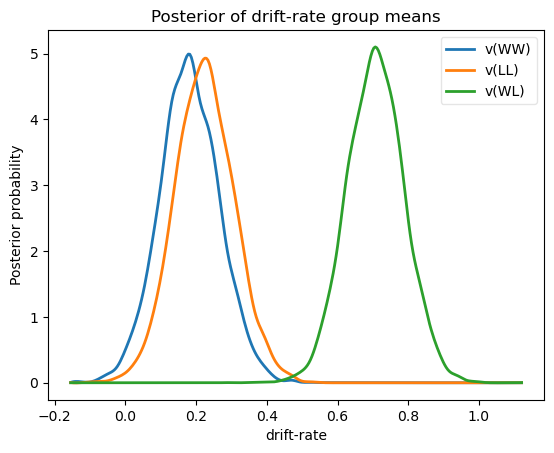

In [24]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [25]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.3596875
P(LL > WL) =  6.25e-05


In [26]:
print("Lumped model DIC: %f" % m1.dic)
print("Stimulus model DIC: %f" % m_stim_all.dic)

Lumped model DIC: 10974.513962
Stimulus model DIC: 10786.961611


## Within-subject effects

In [27]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

The original code in the tutorial was:

```
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
m_within_subj.sample(5000, burn=200)
```

Here we used four chains for parallel processing

In [28]:
def run_m_reg(id, data=None, samples=None, burn=None, save_name="cavanagh2011_reg"): 
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    m = hddm.HDDMRegressor(data,
                           "v ~ C(stim, Treatment('WL'))")
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [29]:
m_reg_list = p_map(partial(run_m_reg, data=data, samples=5000, burn=1000),
                   range(chains))

  0%|          | 0/4 [00:00<?, ?it/s]

Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]
Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])



Adding these covariates:

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])



['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [                  0%                  ] 2 of 5000 complete in 0.5 sec[                  0%                  ] 2 of 5000 complete in 0.6 sec[                  0%                  ] 2 of 5000 complete in 0.6 sec[                  0%                  ] 2 of 5000 complete in 0.6 sec[                  0%                  ] 4 of 5000 complete in 1.1 sec[                  0%                  ] 4 of 5000 complete in 1.2 sec[                  0%                  ] 3 of 5000 complete in 1.2 sec[                  0%                  ] 4 of 5000 complete in 1.3 sec[                  0%                  ] 5 of 5000 complete in 1.7 sec[                  0%                  ] 7 of 5000 complete in 1.8 sec[                  0%                  ] 7 of 5000 complete in 1.8 sec[                  0%                  ] 7 of 5000 complete in 2.0 sec[                  0%                  ] 8 of 5000 complete in 2.3 sec[                  0%                  ] 10 of 5000 complete in 2.4 sec[                 

 [                  1%                  ] 85 of 5000 complete in 18.0 sec[                  1%                  ] 86 of 5000 complete in 18.2 sec[                  1%                  ] 88 of 5000 complete in 18.4 sec[                  1%                  ] 88 of 5000 complete in 18.5 sec[                  1%                  ] 88 of 5000 complete in 18.5 sec[                  1%                  ] 89 of 5000 complete in 18.8 sec[                  1%                  ] 91 of 5000 complete in 19.0 sec[                  1%                  ] 91 of 5000 complete in 19.2 sec[                  1%                  ] 91 of 5000 complete in 19.2 sec[                  1%                  ] 92 of 5000 complete in 19.5 sec[                  1%                  ] 94 of 5000 complete in 19.6 sec[                  1%                  ] 94 of 5000 complete in 19.7 sec[                  1%                  ] 94 of 5000 complete in 19.8 sec[                  1%                  ] 95 of 5000 complete in

 [-                 3%                  ] 171 of 5000 complete in 35.5 sec[-                 3%                  ] 169 of 5000 complete in 35.5 sec[-                 3%                  ] 172 of 5000 complete in 35.6 sec[-                 3%                  ] 172 of 5000 complete in 35.8 sec[-                 3%                  ] 174 of 5000 complete in 36.1 sec[-                 3%                  ] 172 of 5000 complete in 36.1 sec[-                 3%                  ] 175 of 5000 complete in 36.2 sec[-                 3%                  ] 175 of 5000 complete in 36.5 sec[-                 3%                  ] 177 of 5000 complete in 36.7 sec[-                 3%                  ] 175 of 5000 complete in 36.8 sec[-                 3%                  ] 178 of 5000 complete in 36.9 sec[-                 3%                  ] 178 of 5000 complete in 37.1 sec[-                 3%                  ] 180 of 5000 complete in 37.3 sec[-                 3%                  ] 178 of 50

 --                6%                  ] 337 of 5000 complete in 69.2 secc[-                 5%                  ] 255 of 5000 complete in 52.9 sec[-                 5%                  ] 256 of 5000 complete in 53.1 sec[-                 5%                  ] 256 of 5000 complete in 53.3 sec[-                 5%                  ] 259 of 5000 complete in 53.4 sec[-                 5%                  ] 258 of 5000 complete in 53.5 sec[-                 5%                  ] 259 of 5000 complete in 53.7 sec[-                 5%                  ] 259 of 5000 complete in 53.9 sec[-                 5%                  ] 262 of 5000 complete in 54.0 sec[-                 5%                  ] 261 of 5000 complete in 54.1 sec[-                 5%                  ] 262 of 5000 complete in 54.3 sec  [--                5%                  ] 265 of 5000 complete in 54.6 sec[-                 5%                  ] 262 of 5000 complete in 54.5 sec[--                5%                  ] 264 of 

 ---               8%                  ] 408 of 5000 complete in 85.9 secc[--                6%                  ] 343 of 5000 complete in 70.5 sec[--                6%                  ] 343 of 5000 complete in 70.6 sec[--                6%                  ] 342 of 5000 complete in 70.8 sec[--                6%                  ] 343 of 5000 complete in 71.1 sec  [--                6%                  ] 346 of 5000 complete in 71.2 sec[--                6%                  ] 346 of 5000 complete in 71.1 sec[--                6%                  ] 345 of 5000 complete in 71.4 sec[--                6%                  ] 346 of 5000 complete in 71.7 sec[--                6%                  ] 349 of 5000 complete in 71.7 sec[--                6%                  ] 349 of 5000 complete in 71.8 sec[--                6%                  ] 348 of 5000 complete in 72.0 sec[--                7%                  ] 352 of 5000 complete in 72.3 sec[--                6%                  ] 349 of 

 [---               8%                  ] 425 of 5000 complete in 88.6 sec[---               8%                  ] 424 of 5000 complete in 88.6 sec[---               8%                  ] 423 of 5000 complete in 89.0 sec[---               8%                  ] 424 of 5000 complete in 89.0 sec[---               8%                  ] 428 of 5000 complete in 89.2 sec[---               8%                  ] 427 of 5000 complete in 89.2 sec[---               8%                  ] 426 of 5000 complete in 89.6 sec[---               8%                  ] 427 of 5000 complete in 89.7 sec[---               8%                  ] 431 of 5000 complete in 89.8 sec[---               8%                  ] 430 of 5000 complete in 89.9 sec[---               8%                  ] 429 of 5000 complete in 90.2 sec[---               8%                  ] 429 of 5000 complete in 90.2 sec[---               8%                  ] 434 of 5000 complete in 90.4 sec[---               8%                  ] 433 of 50

 [---              10%                  ] 504 of 5000 complete in 105.8 sec[---              10%                  ] 508 of 5000 complete in 105.9 sec[---              10%                  ] 507 of 5000 complete in 106.1 sec[---              10%                  ] 512 of 5000 complete in 106.4 sec[---              10%                  ] 507 of 5000 complete in 106.5 sec[---              10%                  ] 511 of 5000 complete in 106.5 sec[---              10%                  ] 510 of 5000 complete in 106.7 sec[---              10%                  ] 515 of 5000 complete in 107.0 sec[---              10%                  ] 510 of 5000 complete in 107.1 sec[---              10%                  ] 514 of 5000 complete in 107.1 sec[---              10%                  ] 513 of 5000 complete in 107.3 sec[---              10%                  ] 518 of 5000 complete in 107.6 sec[---              10%                  ] 513 of 5000 complete in 107.7 sec[---              10%                

 [----             11%                  ] 593 of 5000 complete in 123.1 sec[----             11%                  ] 588 of 5000 complete in 123.2 sec[----             11%                  ] 592 of 5000 complete in 123.3 sec[----             11%                  ] 591 of 5000 complete in 123.4 sec[----             11%                  ] 596 of 5000 complete in 123.7 sec[----             11%                  ] 591 of 5000 complete in 123.9 sec[----             11%                  ] 595 of 5000 complete in 124.0 sec[----             11%                  ] 594 of 5000 complete in 124.2 sec[----             11%                  ] 598 of 5000 complete in 124.3 sec[----             11%                  ] 594 of 5000 complete in 124.6 sec[----             11%                  ] 598 of 5000 complete in 124.6 sec[----             11%                  ] 597 of 5000 complete in 124.8 sec[----             12%                  ] 601 of 5000 complete in 124.9 sec[----             11%                

 [-----            13%                  ] 676 of 5000 complete in 140.3 sec[-----            13%                  ] 672 of 5000 complete in 140.4 sec[-----            13%                  ] 676 of 5000 complete in 140.5 sec[-----            13%                  ] 671 of 5000 complete in 140.6 sec[-----            13%                  ] 679 of 5000 complete in 140.8 sec[-----            13%                  ] 675 of 5000 complete in 141.0 sec[-----            13%                  ] 679 of 5000 complete in 141.1 sec[-----            13%                  ] 674 of 5000 complete in 141.2 sec[-----            13%                  ] 682 of 5000 complete in 141.4 sec[-----            13%                  ] 678 of 5000 complete in 141.7 sec[-----            13%                  ] 682 of 5000 complete in 141.7 sec[-----            13%                  ] 677 of 5000 complete in 141.8 sec[-----            13%                  ] 685 of 5000 complete in 142.1 sec[-----            13%                

 ------           16%                  ] 803 of 5000 complete in 167.7 secc[-----            15%                  ] 760 of 5000 complete in 157.7 sec[-----            15%                  ] 756 of 5000 complete in 157.8 sec[-----            15%                  ] 760 of 5000 complete in 157.8 sec[-----            15%                  ] 755 of 5000 complete in 158.0 sec[-----            15%                  ] 763 of 5000 complete in 158.3 sec[-----            15%                  ] 759 of 5000 complete in 158.4 sec[-----            15%                  ] 763 of 5000 complete in 158.4 sec[-----            15%                  ] 758 of 5000 complete in 158.6 sec[-----            15%                  ] 766 of 5000 complete in 158.9 sec[-----            15%                  ] 766 of 5000 complete in 159.0 sec[-----            15%                  ] 762 of 5000 complete in 159.0 sec[-----            15%                  ] 761 of 5000 complete in 159.2 sec[-----            15%                

 [------           16%                  ] 837 of 5000 complete in 174.5 sec[------           16%                  ] 844 of 5000 complete in 175.0 sec[------           16%                  ] 844 of 5000 complete in 175.0 sec[------           16%                  ] 839 of 5000 complete in 175.1 sec[------           16%                  ] 840 of 5000 complete in 175.2 sec[------           16%                  ] 847 of 5000 complete in 175.5 sec[------           16%                  ] 847 of 5000 complete in 175.6 sec[------           16%                  ] 842 of 5000 complete in 175.7 sec[------           16%                  ] 843 of 5000 complete in 175.8 sec[------           17%                  ] 850 of 5000 complete in 176.2 sec[------           17%                  ] 850 of 5000 complete in 176.2 sec[------           16%                  ] 845 of 5000 complete in 176.3 sec[------           16%                  ] 846 of 5000 complete in 176.4 sec[------           17%                

 [-------          18%                  ] 925 of 5000 complete in 191.7 sec[------           18%                  ] 921 of 5000 complete in 191.9 sec [-------          18%                  ] 928 of 5000 complete in 192.2 sec [-------          18%                  ] 923 of 5000 complete in 192.1 sec[-------          18%                  ] 928 of 5000 complete in 192.4 sec[-------          18%                  ] 924 of 5000 complete in 192.5 sec[-------          18%                  ] 926 of 5000 complete in 192.8 sec[-------          18%                  ] 931 of 5000 complete in 192.8 sec[-------          18%                  ] 931 of 5000 complete in 193.0 sec[-------          18%                  ] 927 of 5000 complete in 193.1 sec[-------          18%                  ] 934 of 5000 complete in 193.4 sec[-------          18%                  ] 929 of 5000 complete in 193.4 sec[-------          18%                  ] 934 of 5000 complete in 193.7 sec[-------          18%              

 [-------          20%                  ] 1002 of 5000 complete in 208.7 sec[-------          20%                  ] 1009 of 5000 complete in 208.8 sec[-------          20%                  ] 1012 of 5000 complete in 209.0 sec[-------          20%                  ] 1007 of 5000 complete in 209.3 sec[-------          20%                  ] 1005 of 5000 complete in 209.4 sec[-------          20%                  ] 1012 of 5000 complete in 209.5 sec[-------          20%                  ] 1015 of 5000 complete in 209.6 sec[-------          20%                  ] 1010 of 5000 complete in 209.9 sec[-------          20%                  ] 1008 of 5000 complete in 210.0 sec[-------          20%                  ] 1015 of 5000 complete in 210.1 sec[-------          20%                  ] 1018 of 5000 complete in 210.2 sec[-------          20%                  ] 1011 of 5000 complete in 210.6 sec[-------          20%                  ] 1013 of 5000 complete in 210.6 sec[-------          20%   

 [--------         21%                  ] 1090 of 5000 complete in 225.8 sec[--------         21%                  ] 1085 of 5000 complete in 225.9 sec[--------         21%                  ] 1088 of 5000 complete in 226.0 sec[--------         21%                  ] 1096 of 5000 complete in 226.4 sec[--------         21%                  ] 1093 of 5000 complete in 226.4 sec[--------         21%                  ] 1088 of 5000 complete in 226.5 sec[--------         21%                  ] 1091 of 5000 complete in 226.6 sec[--------         21%                  ] 1099 of 5000 complete in 226.9 sec[--------         21%                  ] 1096 of 5000 complete in 227.0 sec[--------         21%                  ] 1091 of 5000 complete in 227.1 sec[--------         21%                  ] 1094 of 5000 complete in 227.3 sec[--------         22%                  ] 1102 of 5000 complete in 227.6 sec[--------         21%                  ] 1099 of 5000 complete in 227.6 sec[--------         21%   

 --------         23%                  ] 1181 of 5000 complete in 245.0 secc[--------         23%                  ] 1177 of 5000 complete in 243.0 sec[--------         23%                  ] 1174 of 5000 complete in 243.0 sec[--------         23%                  ] 1169 of 5000 complete in 243.2 sec[--------         23%                  ] 1172 of 5000 complete in 243.3 sec[--------         23%                  ] 1180 of 5000 complete in 243.6 sec[--------         23%                  ] 1177 of 5000 complete in 243.6 sec[--------         23%                  ] 1172 of 5000 complete in 243.8 sec[--------         23%                  ] 1175 of 5000 complete in 243.9 sec[--------         23%                  ] 1183 of 5000 complete in 244.2 sec[--------         23%                  ] 1180 of 5000 complete in 244.2 sec[--------         23%                  ] 1175 of 5000 complete in 244.4 sec[--------         23%                  ] 1178 of 5000 complete in 244.4 sec[---------        23%   

 ---------        25%                  ] 1276 of 5000 complete in 264.0 secc[---------        25%                  ] 1252 of 5000 complete in 259.8 sec[---------        25%                  ] 1261 of 5000 complete in 260.4 sec[---------        25%                  ] 1253 of 5000 complete in 260.4 sec[---------        25%                  ] 1258 of 5000 complete in 260.4 sec[---------        25%                  ] 1255 of 5000 complete in 260.4 sec[---------        25%                  ] 1264 of 5000 complete in 261.0 sec  [---------        25%                  ] 1261 of 5000 complete in 261.0 sec[---------        25%                  ] 1258 of 5000 complete in 261.0 sec[---------        25%                  ] 1256 of 5000 complete in 261.1 sec[---------        25%                  ] 1264 of 5000 complete in 261.6 sec[---------        25%                  ] 1267 of 5000 complete in 261.6 sec[---------        25%                  ] 1261 of 5000 complete in 261.6 sec[---------        25% 

 [----------       26%                  ] 1342 of 5000 complete in 276.9 sec[----------       26%                  ] 1339 of 5000 complete in 277.0 sec[----------       26%                  ] 1334 of 5000 complete in 277.1 sec[----------       26%                  ] 1339 of 5000 complete in 277.4 sec[----------       26%                  ] 1345 of 5000 complete in 277.6 sec[----------       26%                  ] 1342 of 5000 complete in 277.6 sec[----------       26%                  ] 1337 of 5000 complete in 277.7 sec[----------       26%                  ] 1342 of 5000 complete in 278.0 sec[----------       26%                  ] 1348 of 5000 complete in 278.2 sec[----------       26%                  ] 1345 of 5000 complete in 278.3 sec[----------       26%                  ] 1340 of 5000 complete in 278.3 sec[----------       26%                  ] 1345 of 5000 complete in 278.6 sec[----------       27%                  ] 1351 of 5000 complete in 278.8 sec[----------       26%   

 -----------      29%                  ] 1475 of 5000 complete in 306.2 secc[----------       28%                  ] 1420 of 5000 complete in 293.9 sec[----------       28%                  ] 1426 of 5000 complete in 294.1 sec[----------       28%                  ] 1418 of 5000 complete in 294.4 sec[----------       28%                  ] 1423 of 5000 complete in 294.5 sec[----------       28%                  ] 1423 of 5000 complete in 294.5 sec[----------       28%                  ] 1429 of 5000 complete in 294.7 sec[----------       28%                  ] 1421 of 5000 complete in 295.0 sec[----------       28%                  ] 1426 of 5000 complete in 295.1 sec[----------       28%                  ] 1426 of 5000 complete in 295.1 sec[----------       28%                  ] 1432 of 5000 complete in 295.3 sec[----------       28%                  ] 1424 of 5000 complete in 295.6 sec[----------       28%                  ] 1429 of 5000 complete in 295.7 sec[----------       28%   

 -----------      30%                  ] 1505 of 5000 complete in 312.3 secc[-----------      30%                  ] 1504 of 5000 complete in 311.2 sec[-----------      30%                  ] 1510 of 5000 complete in 311.3 sec[-----------      30%                  ] 1507 of 5000 complete in 311.7 sec[-----------      30%                  ] 1502 of 5000 complete in 311.7 sec[-----------      30%                  ] 1507 of 5000 complete in 311.8 sec[-----------      30%                  ] 1513 of 5000 complete in 311.9 sec [-----------      30%                  ] 1510 of 5000 complete in 312.3 sec[-----------      30%                  ] 1510 of 5000 complete in 312.5 sec[-----------      30%                  ] 1516 of 5000 complete in 312.5 sec[-----------      30%                  ] 1513 of 5000 complete in 312.9 sec[-----------      30%                  ] 1508 of 5000 complete in 312.9 sec[-----------      30%                  ] 1513 of 5000 complete in 313.1 sec[-----------      30%  

 [------------     31%                  ] 1588 of 5000 complete in 328.3 sec[------------     31%                  ] 1583 of 5000 complete in 328.3 sec[------------     31%                  ] 1588 of 5000 complete in 328.4 sec[------------     31%                  ] 1594 of 5000 complete in 328.5 sec[------------     31%                  ] 1586 of 5000 complete in 328.9 sec[------------     31%                  ] 1591 of 5000 complete in 328.9 sec[------------     31%                  ] 1591 of 5000 complete in 328.9 sec[------------     31%                  ] 1597 of 5000 complete in 329.1 sec[------------     31%                  ] 1594 of 5000 complete in 329.5 sec[------------     31%                  ] 1589 of 5000 complete in 329.5 sec[------------     31%                  ] 1594 of 5000 complete in 329.6 sec[------------     32%                  ] 1600 of 5000 complete in 329.7 sec[------------     31%                  ] 1597 of 5000 complete in 330.1 sec[------------     31%   

 -------------    35%                  ] 1750 of 5000 complete in 361.5 secc[------------     33%                  ] 1675 of 5000 complete in 345.1 sec[------------     33%                  ] 1667 of 5000 complete in 345.3 sec[------------     33%                  ] 1672 of 5000 complete in 345.4 sec[------------     33%                  ] 1672 of 5000 complete in 345.4 sec[------------     33%                  ] 1678 of 5000 complete in 345.7 sec[------------     33%                  ] 1670 of 5000 complete in 346.0 sec[------------     33%                  ] 1675 of 5000 complete in 346.1 sec[------------     33%                  ] 1675 of 5000 complete in 346.1 sec[------------     33%                  ] 1681 of 5000 complete in 346.2 sec[------------     33%                  ] 1673 of 5000 complete in 346.6 sec[------------     33%                  ] 1678 of 5000 complete in 346.7 sec[------------     33%                  ] 1678 of 5000 complete in 346.7 sec[------------     33%   

 [-------------    35%                  ] 1759 of 5000 complete in 362.2 sec[-------------    35%                  ] 1750 of 5000 complete in 362.2 sec[-------------    35%                  ] 1753 of 5000 complete in 362.3 sec[-------------    35%                  ] 1756 of 5000 complete in 362.7 sec[-------------    35%                  ] 1762 of 5000 complete in 362.8 sec[-------------    35%                  ] 1753 of 5000 complete in 362.8 sec[-------------    35%                  ] 1756 of 5000 complete in 362.9 sec[-------------    35%                  ] 1756 of 5000 complete in 363.4 sec[-------------    35%                  ] 1759 of 5000 complete in 363.4 sec[-------------    35%                  ] 1765 of 5000 complete in 363.5 sec[-------------    35%                  ] 1759 of 5000 complete in 363.5 sec[-------------    35%                  ] 1759 of 5000 complete in 364.0 sec[-------------    35%                  ] 1762 of 5000 complete in 364.0 sec[-------------    35%   

 [-------------    36%                  ] 1834 of 5000 complete in 379.1 sec[-------------    36%                  ] 1834 of 5000 complete in 379.3 sec[-------------    36%                  ] 1837 of 5000 complete in 379.4 sec[--------------   36%                  ] 1843 of 5000 complete in 379.6 sec[-------------    36%                  ] 1837 of 5000 complete in 379.7 sec[-------------    36%                  ] 1837 of 5000 complete in 379.9 sec[-------------    36%                  ] 1840 of 5000 complete in 380.0 sec[--------------   36%                  ] 1846 of 5000 complete in 380.2 sec[-------------    36%                  ] 1840 of 5000 complete in 380.3 sec[-------------    36%                  ] 1840 of 5000 complete in 380.6 sec[--------------   36%                  ] 1843 of 5000 complete in 380.6 sec[--------------   36%                  ] 1849 of 5000 complete in 380.8 sec[--------------   36%                  ] 1843 of 5000 complete in 380.9 sec[--------------   36%   

 ---------------  39%                  ] 1999 of 5000 complete in 412.7 secc[--------------   38%                  ] 1918 of 5000 complete in 396.1 sec[--------------   38%                  ] 1924 of 5000 complete in 396.2 sec[--------------   38%                  ] 1918 of 5000 complete in 396.3 sec[--------------   38%                  ] 1921 of 5000 complete in 396.7 sec[--------------   38%                  ] 1921 of 5000 complete in 396.8 sec[--------------   38%                  ] 1927 of 5000 complete in 396.8 sec[--------------   38%                  ] 1921 of 5000 complete in 396.9 sec[--------------   38%                  ] 1924 of 5000 complete in 397.3 sec[--------------   38%                  ] 1924 of 5000 complete in 397.4 sec[--------------   38%                  ] 1930 of 5000 complete in 397.4 sec[--------------   38%                  ] 1924 of 5000 complete in 397.5 sec[--------------   38%                  ] 1927 of 5000 complete in 398.0 sec[--------------   38%   

 ---------------  41%                  ] 2080 of 5000 complete in 429.4 sec [---------------  40%                  ] 2002 of 5000 complete in 413.3 sec[---------------  40%                  ] 2005 of 5000 complete in 413.8 sec[---------------  40%                  ] 2005 of 5000 complete in 413.9 sec[---------------  40%                  ] 2011 of 5000 complete in 414.0 sec[---------------  40%                  ] 2005 of 5000 complete in 413.9 sec[---------------  40%                  ] 2008 of 5000 complete in 414.4 sec[---------------  40%                  ] 2008 of 5000 complete in 414.5 sec[---------------  40%                  ] 2014 of 5000 complete in 414.6 sec[---------------  40%                  ] 2008 of 5000 complete in 414.6 sec[---------------  40%                  ] 2011 of 5000 complete in 415.1 sec[---------------  40%                  ] 2011 of 5000 complete in 415.1 sec[---------------  40%                  ] 2017 of 5000 complete in 415.2 sec[---------------  40%   

 ---------------- 43%                  ] 2155 of 5000 complete in 443.6 secc[---------------  41%                  ] 2089 of 5000 complete in 431.1 sec[---------------  41%                  ] 2095 of 5000 complete in 431.3 sec[---------------  41%                  ] 2089 of 5000 complete in 431.2 sec[---------------  41%                  ] 2089 of 5000 complete in 431.3 sec[---------------  41%                  ] 2092 of 5000 complete in 431.7 sec[---------------  41%                  ] 2098 of 5000 complete in 431.9 sec[---------------  41%                  ] 2092 of 5000 complete in 431.9 sec[---------------  41%                  ] 2092 of 5000 complete in 432.0 sec[---------------  41%                  ] 2095 of 5000 complete in 432.3 sec[---------------  41%                  ] 2095 of 5000 complete in 432.5 sec[---------------  42%                  ] 2101 of 5000 complete in 432.5 sec[---------------  41%                  ] 2095 of 5000 complete in 432.6 sec[---------------  41%   

 ---------------- 44%                  ] 2235 of 5000 complete in 461.1 secec[---------------- 43%                  ] 2176 of 5000 complete in 448.0 sec[---------------- 43%                  ] 2173 of 5000 complete in 448.1 sec[---------------- 43%                  ] 2173 of 5000 complete in 448.2 sec[---------------- 43%                  ] 2179 of 5000 complete in 448.6 sec[---------------- 43%                  ] 2173 of 5000 complete in 448.6 sec[---------------- 43%                  ] 2176 of 5000 complete in 448.7 sec[---------------- 43%                  ] 2176 of 5000 complete in 448.8 sec[---------------- 43%                  ] 2182 of 5000 complete in 449.2 sec[---------------- 43%                  ] 2176 of 5000 complete in 449.2 sec[---------------- 43%                  ] 2179 of 5000 complete in 449.3 sec[---------------- 43%                  ] 2179 of 5000 complete in 449.5 sec[---------------- 43%                  ] 2179 of 5000 complete in 449.8 sec[---------------- 43%  

 [-----------------45%                  ] 2253 of 5000 complete in 465.2 sec[-----------------45%                  ] 2260 of 5000 complete in 465.4 sec[-----------------45%                  ] 2256 of 5000 complete in 465.3 sec[-----------------45%                  ] 2254 of 5000 complete in 465.4 sec[-----------------45%                  ] 2256 of 5000 complete in 465.8 sec[-----------------45%                  ] 2263 of 5000 complete in 466.0 sec[-----------------45%                  ] 2259 of 5000 complete in 466.0 sec[-----------------45%                  ] 2257 of 5000 complete in 466.0 sec[-----------------45%                  ] 2259 of 5000 complete in 466.4 sec[-----------------45%                  ] 2266 of 5000 complete in 466.6 sec[-----------------45%                  ] 2260 of 5000 complete in 466.6 sec[-----------------45%                  ] 2262 of 5000 complete in 466.6 sec[-----------------45%                  ] 2262 of 5000 complete in 467.0 sec[-----------------45%   

 [-----------------46%                  ] 2341 of 5000 complete in 481.9 sec[-----------------46%                  ] 2337 of 5000 complete in 482.0 sec[-----------------46%                  ] 2336 of 5000 complete in 482.2 sec[-----------------46%                  ] 2338 of 5000 complete in 482.4 sec[-----------------46%                  ] 2344 of 5000 complete in 482.5 sec[-----------------46%                  ] 2340 of 5000 complete in 482.6 sec[-----------------46%                  ] 2339 of 5000 complete in 482.7 sec[-----------------46%                  ] 2341 of 5000 complete in 483.0 sec[-----------------46%                  ] 2347 of 5000 complete in 483.1 sec[-----------------46%                  ] 2343 of 5000 complete in 483.3 sec[-----------------46%                  ] 2342 of 5000 complete in 483.3 sec[-----------------46%                  ] 2344 of 5000 complete in 483.6 sec[-----------------47%                  ] 2350 of 5000 complete in 483.8 sec[-----------------46%   

 -----------------49%                  ] 2488 of 5000 complete in 511.7 secc[-----------------48%                  ] 2419 of 5000 complete in 498.9 sec[-----------------48%                  ] 2425 of 5000 complete in 499.0 sec[-----------------48%                  ] 2421 of 5000 complete in 499.3 sec[-----------------48%                  ] 2420 of 5000 complete in 499.4 sec[-----------------48%                  ] 2422 of 5000 complete in 499.6 sec[-----------------48%                  ] 2428 of 5000 complete in 499.7 sec[-----------------48%                  ] 2424 of 5000 complete in 499.9 sec[-----------------48%                  ] 2423 of 5000 complete in 500.0 sec[-----------------48%                  ] 2425 of 5000 complete in 500.2 sec[-----------------48%                  ] 2431 of 5000 complete in 500.3 sec[-----------------48%                  ] 2427 of 5000 complete in 500.6 sec[-----------------48%                  ] 2426 of 5000 complete in 500.6 sec[-----------------48%   

 [-----------------50%                  ] 2509 of 5000 complete in 515.9 sec[-----------------50%                  ] 2502 of 5000 complete in 515.9 sec[-----------------50%                  ] 2501 of 5000 complete in 516.1 sec[-----------------50%                  ] 2506 of 5000 complete in 516.5 sec[-----------------50%                  ] 2505 of 5000 complete in 516.5 sec[-----------------50%                  ] 2512 of 5000 complete in 516.6 sec[-----------------50%                  ] 2504 of 5000 complete in 516.7 sec[-----------------50%                  ] 2508 of 5000 complete in 517.0 sec[-----------------50%                  ] 2509 of 5000 complete in 517.1 sec[-----------------50%                  ] 2515 of 5000 complete in 517.2 sec[-----------------50%                  ] 2507 of 5000 complete in 517.3 sec[-----------------50%                  ] 2511 of 5000 complete in 517.6 sec[-----------------50%                  ] 2512 of 5000 complete in 517.8 sec[-----------------50%   

 -----------------52%                  ] 2618 of 5000 complete in 540.1 secc[-----------------51%                  ] 2585 of 5000 complete in 532.9 sec[-----------------51%                  ] 2592 of 5000 complete in 533.1 sec[-----------------51%                  ] 2585 of 5000 complete in 533.2 sec[-----------------51%                  ] 2587 of 5000 complete in 533.4 sec[-----------------51%                  ] 2588 of 5000 complete in 533.5 sec[-----------------51%                  ] 2595 of 5000 complete in 533.6 sec[-----------------51%                  ] 2588 of 5000 complete in 533.9 sec[-----------------51%                  ] 2590 of 5000 complete in 534.0 sec[-----------------51%                  ] 2591 of 5000 complete in 534.1 sec[-----------------51%                  ] 2598 of 5000 complete in 534.3 sec[-----------------51%                  ] 2591 of 5000 complete in 534.5 sec[-----------------51%                  ] 2593 of 5000 complete in 534.6 sec[-----------------51%   

 [-----------------53%                  ] 2666 of 5000 complete in 549.7 sec[-----------------53%                  ] 2668 of 5000 complete in 549.8 sec[-----------------53%                  ] 2676 of 5000 complete in 550.1 sec[-----------------53%                  ] 2669 of 5000 complete in 550.2 sec[-----------------53%                  ] 2669 of 5000 complete in 550.4 sec[-----------------53%                  ] 2671 of 5000 complete in 550.4 sec[-----------------53%                  ] 2679 of 5000 complete in 550.7 sec[-----------------53%                  ] 2672 of 5000 complete in 550.8 sec[-----------------53%                  ] 2672 of 5000 complete in 551.0 sec[-----------------53%                  ] 2674 of 5000 complete in 551.1 sec[-----------------53%                  ] 2682 of 5000 complete in 551.3 sec[-----------------53%                  ] 2675 of 5000 complete in 551.4 sec  [-----------------53%                  ] 2677 of 5000 complete in 551.7 sec[-----------------53% 

 [-----------------55%                  ] 2757 of 5000 complete in 566.7 sec[-----------------55%                  ] 2750 of 5000 complete in 566.8 sec[-----------------55%                  ] 2752 of 5000 complete in 566.9 sec[-----------------55%                  ] 2750 of 5000 complete in 567.1 sec[-----------------55%                  ] 2760 of 5000 complete in 567.4 sec[-----------------55%                  ] 2753 of 5000 complete in 567.4 sec[-----------------55%                  ] 2755 of 5000 complete in 567.5 sec[-----------------55%                  ] 2753 of 5000 complete in 567.7 sec[-----------------55%                  ] 2763 of 5000 complete in 568.0 sec[-----------------55%                  ] 2756 of 5000 complete in 568.0 sec[-----------------55%                  ] 2758 of 5000 complete in 568.1 sec[-----------------55%                  ] 2756 of 5000 complete in 568.3 sec[-----------------55%-                 ] 2766 of 5000 complete in 568.6 sec[-----------------55%   

 -----------------57%-                 ] 2892 of 5000 complete in 594.3 secc[-----------------56%-                 ] 2831 of 5000 complete in 583.5 sec[-----------------56%-                 ] 2836 of 5000 complete in 583.6 sec[-----------------56%-                 ] 2841 of 5000 complete in 583.8 sec[-----------------56%-                 ] 2834 of 5000 complete in 583.9 sec[-----------------56%-                 ] 2834 of 5000 complete in 584.1 sec[-----------------56%-                 ] 2839 of 5000 complete in 584.3 sec[-----------------56%-                 ] 2844 of 5000 complete in 584.5 sec[-----------------56%-                 ] 2837 of 5000 complete in 584.5 sec[-----------------56%-                 ] 2837 of 5000 complete in 584.7 sec[-----------------56%-                 ] 2842 of 5000 complete in 584.8 sec[-----------------56%-                 ] 2847 of 5000 complete in 585.1 sec[-----------------56%-                 ] 2840 of 5000 complete in 585.2 sec[-----------------56%-  

 [-----------------58%--                ] 2920 of 5000 complete in 600.9 sec[-----------------58%--                ] 2925 of 5000 complete in 601.0 sec[-----------------58%--                ] 2918 of 5000 complete in 601.2 sec[-----------------58%--                ] 2918 of 5000 complete in 601.3 sec[-----------------58%--                ] 2923 of 5000 complete in 601.5 sec[-----------------58%--                ] 2928 of 5000 complete in 601.6 sec[-----------------58%--                ] 2921 of 5000 complete in 601.7 sec[-----------------58%--                ] 2921 of 5000 complete in 601.9 sec[-----------------58%--                ] 2926 of 5000 complete in 602.0 sec[-----------------58%--                ] 2931 of 5000 complete in 602.2 sec[-----------------58%--                ] 2924 of 5000 complete in 602.3 sec[-----------------58%--                ] 2924 of 5000 complete in 602.5 sec[-----------------58%--                ] 2929 of 5000 complete in 602.6 sec[-----------------58%-- 

 -----------------61%---               ] 3064 of 5000 complete in 630.1 secc[-----------------60%--                ] 3004 of 5000 complete in 617.8 sec[-----------------60%--                ] 3001 of 5000 complete in 618.1 sec[-----------------60%--                ] 3009 of 5000 complete in 618.2 sec[-----------------59%--                ] 2999 of 5000 complete in 618.3 sec[-----------------60%--                ] 3007 of 5000 complete in 618.5 sec[-----------------60%--                ] 3003 of 5000 complete in 618.6 sec[-----------------60%--                ] 3012 of 5000 complete in 618.9 sec[-----------------60%--                ] 3002 of 5000 complete in 618.9 sec[-----------------60%--                ] 3010 of 5000 complete in 619.1 sec[-----------------60%--                ] 3006 of 5000 complete in 619.2 sec[-----------------60%--                ] 3015 of 5000 complete in 619.5 sec[-----------------60%--                ] 3005 of 5000 complete in 619.5 sec[-----------------60%-- 

 [-----------------61%---               ] 3088 of 5000 complete in 635.1 sec[-----------------61%---               ] 3080 of 5000 complete in 635.2 sec[-----------------61%---               ] 3084 of 5000 complete in 635.4 sec[-----------------61%---               ] 3093 of 5000 complete in 635.6 sec[-----------------61%---               ] 3091 of 5000 complete in 635.6 sec[-----------------61%---               ] 3083 of 5000 complete in 635.9 sec[-----------------61%---               ] 3087 of 5000 complete in 636.0 sec[-----------------61%---               ] 3096 of 5000 complete in 636.2 sec[-----------------61%---               ] 3094 of 5000 complete in 636.2 sec[-----------------61%---               ] 3086 of 5000 complete in 636.5 sec[-----------------61%---               ] 3090 of 5000 complete in 636.6 sec[-----------------61%---               ] 3099 of 5000 complete in 636.8 sec[-----------------61%---               ] 3097 of 5000 complete in 636.8 sec[-----------------61%---

 -----------------63%----              ] 3189 of 5000 complete in 654.9 secc[-----------------63%----              ] 3174 of 5000 complete in 651.9 sec[-----------------63%----              ] 3165 of 5000 complete in 651.9 sec[-----------------63%----              ] 3164 of 5000 complete in 652.3 sec[-----------------63%----              ] 3175 of 5000 complete in 652.4 sec [-----------------63%----              ] 3177 of 5000 complete in 652.5 sec[-----------------63%----              ] 3168 of 5000 complete in 652.5 sec [-----------------63%----              ] 3167 of 5000 complete in 652.9 sec[-----------------63%----              ] 3178 of 5000 complete in 653.0 sec[-----------------63%----              ] 3171 of 5000 complete in 653.0 sec[-----------------63%----              ] 3180 of 5000 complete in 653.2 sec[-----------------63%----              ] 3181 of 5000 complete in 653.5 sec[-----------------63%----              ] 3170 of 5000 complete in 653.5 sec[-----------------63%-

 [-----------------64%----              ] 3245 of 5000 complete in 668.7 sec[-----------------65%----              ] 3256 of 5000 complete in 668.8 sec[-----------------64%----              ] 3249 of 5000 complete in 668.8 sec[-----------------65%----              ] 3258 of 5000 complete in 669.0 sec[-----------------65%----              ] 3259 of 5000 complete in 669.4 sec[-----------------64%----              ] 3248 of 5000 complete in 669.4 sec[-----------------65%----              ] 3252 of 5000 complete in 669.4 sec[-----------------65%----              ] 3261 of 5000 complete in 669.6 sec[-----------------65%----              ] 3262 of 5000 complete in 670.0 sec[-----------------65%----              ] 3251 of 5000 complete in 669.9 sec[-----------------65%----              ] 3255 of 5000 complete in 670.1 sec[-----------------65%----              ] 3264 of 5000 complete in 670.3 sec[-----------------65%----              ] 3254 of 5000 complete in 670.5 sec[-----------------65%---

 [-----------------66%-----             ] 3337 of 5000 complete in 685.4 sec[-----------------66%-----             ] 3339 of 5000 complete in 685.5 sec[-----------------66%-----             ] 3329 of 5000 complete in 685.7 sec[-----------------66%-----             ] 3333 of 5000 complete in 685.9 sec[-----------------66%-----             ] 3340 of 5000 complete in 686.0 sec[-----------------66%-----             ] 3342 of 5000 complete in 686.1 sec[-----------------66%-----             ] 3332 of 5000 complete in 686.4 sec[-----------------66%-----             ] 3336 of 5000 complete in 686.6 sec[-----------------66%-----             ] 3343 of 5000 complete in 686.7 sec[-----------------66%-----             ] 3345 of 5000 complete in 686.7 sec[-----------------66%-----             ] 3335 of 5000 complete in 687.0 sec[-----------------66%-----             ] 3339 of 5000 complete in 687.1 sec[-----------------66%-----             ] 3346 of 5000 complete in 687.3 sec[-----------------66%---

 [-----------------68%-----             ] 3410 of 5000 complete in 702.4 sec[-----------------68%-----             ] 3421 of 5000 complete in 702.5 sec[-----------------68%-----             ] 3414 of 5000 complete in 702.7 sec[-----------------68%------            ] 3423 of 5000 complete in 702.8 sec[-----------------68%-----             ] 3413 of 5000 complete in 703.1 sec[-----------------68%------            ] 3424 of 5000 complete in 703.2 sec[-----------------68%-----             ] 3417 of 5000 complete in 703.3 sec[-----------------68%------            ] 3426 of 5000 complete in 703.4 sec[-----------------68%------            ] 3427 of 5000 complete in 703.8 sec[-----------------68%-----             ] 3416 of 5000 complete in 703.7 sec[-----------------68%------            ] 3429 of 5000 complete in 704.0 sec[-----------------68%-----             ] 3420 of 5000 complete in 703.9 sec[-----------------68%------            ] 3430 of 5000 complete in 704.4 sec[-----------------68%---

 [-----------------69%------            ] 3495 of 5000 complete in 719.4 sec[-----------------70%------            ] 3504 of 5000 complete in 719.5 sec[-----------------70%------            ] 3505 of 5000 complete in 719.7 sec[-----------------69%------            ] 3494 of 5000 complete in 719.9 sec[-----------------69%------            ] 3498 of 5000 complete in 720.1 sec[-----------------70%------            ] 3507 of 5000 complete in 720.1 sec[-----------------70%------            ] 3508 of 5000 complete in 720.3 sec[-----------------69%------            ] 3497 of 5000 complete in 720.5 sec[-----------------70%------            ] 3510 of 5000 complete in 720.7 sec[-----------------70%------            ] 3501 of 5000 complete in 720.7 sec[-----------------70%------            ] 3511 of 5000 complete in 720.9 sec[-----------------70%------            ] 3500 of 5000 complete in 721.1 sec[-----------------70%------            ] 3513 of 5000 complete in 721.3 sec[-----------------70%---

 [-----------------71%-------           ] 3576 of 5000 complete in 736.1 sec[-----------------71%-------           ] 3574 of 5000 complete in 736.2 sec[-----------------71%-------           ] 3588 of 5000 complete in 736.7 sec[-----------------71%-------           ] 3589 of 5000 complete in 736.7 sec[-----------------71%-------           ] 3579 of 5000 complete in 736.7 sec[-----------------71%-------           ] 3577 of 5000 complete in 736.9 sec[-----------------71%-------           ] 3591 of 5000 complete in 737.3 sec[-----------------71%-------           ] 3592 of 5000 complete in 737.3 sec[-----------------71%-------           ] 3582 of 5000 complete in 737.3 sec[-----------------71%-------           ] 3580 of 5000 complete in 737.5 sec[-----------------71%-------           ] 3594 of 5000 complete in 737.9 sec[-----------------71%-------           ] 3595 of 5000 complete in 737.9 sec[-----------------71%-------           ] 3585 of 5000 complete in 737.9 sec[-----------------71%---

 -----------------74%--------          ] 3727 of 5000 complete in 764.7 secc[-----------------73%-------           ] 3669 of 5000 complete in 753.3 sec[-----------------73%-------           ] 3670 of 5000 complete in 753.3 sec[-----------------73%-------           ] 3658 of 5000 complete in 753.6 sec[-----------------73%-------           ] 3663 of 5000 complete in 753.7 sec[-----------------73%-------           ] 3672 of 5000 complete in 753.9 sec[-----------------73%-------           ] 3673 of 5000 complete in 754.0 sec[-----------------73%-------           ] 3661 of 5000 complete in 754.2 sec[-----------------73%-------           ] 3666 of 5000 complete in 754.3 sec[-----------------73%-------           ] 3675 of 5000 complete in 754.5 sec[-----------------73%-------           ] 3676 of 5000 complete in 754.6 sec[-----------------73%-------           ] 3664 of 5000 complete in 754.8 sec[-----------------73%-------           ] 3669 of 5000 complete in 755.0 sec[-----------------73%---

 [-----------------74%--------          ] 3739 of 5000 complete in 769.8 sec[-----------------75%--------          ] 3753 of 5000 complete in 770.1 sec[-----------------74%--------          ] 3744 of 5000 complete in 770.2 sec[-----------------75%--------          ] 3754 of 5000 complete in 770.2 sec[-----------------74%--------          ] 3742 of 5000 complete in 770.4 sec[-----------------75%--------          ] 3756 of 5000 complete in 770.7 sec[-----------------75%--------          ] 3757 of 5000 complete in 770.8 sec[-----------------74%--------          ] 3747 of 5000 complete in 770.8 sec[-----------------74%--------          ] 3745 of 5000 complete in 771.1 sec[-----------------75%--------          ] 3759 of 5000 complete in 771.3 sec[-----------------75%--------          ] 3760 of 5000 complete in 771.4 sec[-----------------75%--------          ] 3750 of 5000 complete in 771.4 sec[-----------------74%--------          ] 3748 of 5000 complete in 771.7 sec[-----------------75%---

 [-----------------76%---------         ] 3834 of 5000 complete in 786.8 sec[-----------------76%---------         ] 3835 of 5000 complete in 786.9 sec[-----------------76%---------         ] 3822 of 5000 complete in 787.1 sec[-----------------76%---------         ] 3828 of 5000 complete in 787.3 sec[-----------------76%---------         ] 3837 of 5000 complete in 787.5 sec[-----------------76%---------         ] 3838 of 5000 complete in 787.5 sec[-----------------76%---------         ] 3825 of 5000 complete in 787.7 sec[-----------------76%---------         ] 3831 of 5000 complete in 788.0 sec[-----------------76%---------         ] 3840 of 5000 complete in 788.1 sec[-----------------76%---------         ] 3841 of 5000 complete in 788.1 sec[-----------------76%---------         ] 3828 of 5000 complete in 788.4 sec[-----------------76%---------         ] 3834 of 5000 complete in 788.6 sec[-----------------76%---------         ] 3843 of 5000 complete in 788.7 sec[-----------------76%---

 [-----------------78%---------         ] 3906 of 5000 complete in 803.6 sec[-----------------78%---------         ] 3903 of 5000 complete in 803.9 sec[-----------------78%---------         ] 3919 of 5000 complete in 804.0 sec[-----------------78%---------         ] 3921 of 5000 complete in 804.2 sec[-----------------78%---------         ] 3909 of 5000 complete in 804.2 sec[-----------------78%---------         ] 3906 of 5000 complete in 804.5 sec[-----------------78%---------         ] 3922 of 5000 complete in 804.6 sec[-----------------78%---------         ] 3924 of 5000 complete in 804.8 sec[-----------------78%---------         ] 3912 of 5000 complete in 804.8 sec[-----------------78%---------         ] 3909 of 5000 complete in 805.1 sec[-----------------78%---------         ] 3925 of 5000 complete in 805.3 sec[-----------------78%---------         ] 3915 of 5000 complete in 805.4 sec[-----------------78%---------         ] 3927 of 5000 complete in 805.5 sec[-----------------78%---

[-----------------81%----------        ] 4065 of 5000 complete in 837.9 secc[-----------------79%----------        ] 3990 of 5000 complete in 821.1 sec[-----------------80%----------        ] 4002 of 5000 complete in 821.2 sec[-----------------80%----------        ] 4003 of 5000 complete in 821.2 sec[-----------------79%----------        ] 3987 of 5000 complete in 821.5 sec[-----------------79%----------        ] 3993 of 5000 complete in 821.7 sec[-----------------80%----------        ] 4005 of 5000 complete in 821.8 sec[-----------------80%----------        ] 4006 of 5000 complete in 821.8 sec[-----------------79%----------        ] 3990 of 5000 complete in 822.1 sec[-----------------79%----------        ] 3996 of 5000 complete in 822.3 sec[-----------------80%----------        ] 4008 of 5000 complete in 822.4 sec[-----------------80%----------        ] 4009 of 5000 complete in 822.5 sec[-----------------79%----------        ] 3993 of 5000 complete in 822.8 sec[-----------------79%---

 [-----------------81%-----------       ] 4087 of 5000 complete in 838.2 sec[-----------------81%----------        ] 4074 of 5000 complete in 838.5 sec[-----------------81%----------        ] 4068 of 5000 complete in 838.5 sec[-----------------81%-----------       ] 4086 of 5000 complete in 838.6 sec[-----------------81%-----------       ] 4090 of 5000 complete in 838.8 sec[-----------------81%----------        ] 4077 of 5000 complete in 839.0 sec[-----------------81%-----------       ] 4089 of 5000 complete in 839.1 sec[-----------------81%----------        ] 4071 of 5000 complete in 839.1 sec[-----------------81%-----------       ] 4093 of 5000 complete in 839.4 sec[-----------------81%-----------       ] 4080 of 5000 complete in 839.6 sec[-----------------81%-----------       ] 4092 of 5000 complete in 839.8 sec[-----------------81%----------        ] 4074 of 5000 complete in 839.7 sec[-----------------81%-----------       ] 4096 of 5000 complete in 840.1 sec[-----------------81%---

 -----------------84%------------      ] 4219 of 5000 complete in 865.3 secc[-----------------82%-----------       ] 4148 of 5000 complete in 855.1 sec[-----------------83%-----------       ] 4171 of 5000 complete in 855.6 sec[-----------------83%-----------       ] 4170 of 5000 complete in 855.6 sec[-----------------83%-----------       ] 4158 of 5000 complete in 855.6 sec[-----------------83%-----------       ] 4151 of 5000 complete in 855.7 sec[-----------------83%-----------       ] 4174 of 5000 complete in 856.1 sec[-----------------83%-----------       ] 4173 of 5000 complete in 856.2 sec[-----------------83%-----------       ] 4161 of 5000 complete in 856.3 sec[-----------------83%-----------       ] 4154 of 5000 complete in 856.3 sec[-----------------83%-----------       ] 4177 of 5000 complete in 856.7 sec[-----------------83%-----------       ] 4176 of 5000 complete in 856.8 sec[-----------------83%-----------       ] 4164 of 5000 complete in 856.8 sec[-----------------83%---

 -----------------86%------------      ] 4320 of 5000 complete in 886.1 secc[-----------------84%------------      ] 4232 of 5000 complete in 872.3 sec[-----------------84%------------      ] 4242 of 5000 complete in 872.6 sec[-----------------85%------------      ] 4255 of 5000 complete in 872.7 sec[-----------------85%------------      ] 4254 of 5000 complete in 872.8 sec[-----------------84%------------      ] 4235 of 5000 complete in 872.9 sec[-----------------84%------------      ] 4245 of 5000 complete in 873.2 sec[-----------------85%------------      ] 4258 of 5000 complete in 873.3 sec[-----------------85%------------      ] 4257 of 5000 complete in 873.5 sec[-----------------84%------------      ] 4238 of 5000 complete in 873.5 sec[-----------------84%------------      ] 4248 of 5000 complete in 873.9 sec[-----------------85%------------      ] 4261 of 5000 complete in 874.0 sec[-----------------85%------------      ] 4260 of 5000 complete in 874.1 sec[-----------------84%---

 -----------------87%-------------     ] 4371 of 5000 complete in 899.0 secc[-----------------86%------------      ] 4316 of 5000 complete in 889.4 sec[-----------------86%------------      ] 4338 of 5000 complete in 889.8 sec[-----------------86%------------      ] 4326 of 5000 complete in 889.8 sec[-----------------86%------------      ] 4339 of 5000 complete in 889.9 sec[-----------------86%------------      ] 4319 of 5000 complete in 890.0 sec[-----------------86%------------      ] 4341 of 5000 complete in 890.5 sec[-----------------86%------------      ] 4329 of 5000 complete in 890.4 sec[-----------------86%------------      ] 4342 of 5000 complete in 890.5 sec[-----------------86%------------      ] 4322 of 5000 complete in 890.6 sec[-----------------86%-------------     ] 4344 of 5000 complete in 891.1 sec[-----------------86%-------------     ] 4345 of 5000 complete in 891.1 sec[-----------------86%------------      ] 4332 of 5000 complete in 891.1 sec[-----------------86%---

 [-----------------88%-------------     ] 4407 of 5000 complete in 906.2 sec[-----------------88%-------------     ] 4419 of 5000 complete in 906.4 sec[-----------------88%-------------     ] 4400 of 5000 complete in 906.5 sec[-----------------88%-------------     ] 4423 of 5000 complete in 906.8 sec[-----------------88%-------------     ] 4410 of 5000 complete in 906.8 sec[-----------------88%-------------     ] 4422 of 5000 complete in 907.0 sec[-----------------88%-------------     ] 4403 of 5000 complete in 907.1 sec[-----------------88%-------------     ] 4426 of 5000 complete in 907.4 sec[-----------------88%-------------     ] 4413 of 5000 complete in 907.4 sec[-----------------88%-------------     ] 4425 of 5000 complete in 907.6 sec[-----------------88%-------------     ] 4406 of 5000 complete in 907.7 sec[-----------------88%-------------     ] 4429 of 5000 complete in 908.0 sec[-----------------88%-------------     ] 4416 of 5000 complete in 908.0 sec[-----------------88%---

 -----------------90%--------------    ] 4529 of 5000 complete in 933.0 secc[-----------------90%--------------    ] 4504 of 5000 complete in 923.2 sec[-----------------89%--------------    ] 4491 of 5000 complete in 923.5 sec[-----------------90%--------------    ] 4503 of 5000 complete in 923.7 sec[-----------------89%--------------    ] 4484 of 5000 complete in 923.7 sec[-----------------90%--------------    ] 4507 of 5000 complete in 923.8 sec[-----------------89%--------------    ] 4494 of 5000 complete in 924.1 sec[-----------------90%--------------    ] 4506 of 5000 complete in 924.3 sec[-----------------89%--------------    ] 4487 of 5000 complete in 924.3 sec[-----------------90%--------------    ] 4510 of 5000 complete in 924.4 sec[-----------------89%--------------    ] 4497 of 5000 complete in 924.7 sec[-----------------90%--------------    ] 4509 of 5000 complete in 925.0 sec[-----------------90%--------------    ] 4513 of 5000 complete in 925.0 sec[-----------------89%---

 -----------------92%---------------   ] 4622 of 5000 complete in 952.2 secc[-----------------91%--------------    ] 4588 of 5000 complete in 940.7 sec[-----------------91%--------------    ] 4575 of 5000 complete in 940.7 sec[-----------------91%--------------    ] 4587 of 5000 complete in 940.9 sec[-----------------91%--------------    ] 4568 of 5000 complete in 941.0 sec[-----------------91%--------------    ] 4591 of 5000 complete in 941.2 sec[-----------------91%--------------    ] 4578 of 5000 complete in 941.3 sec[-----------------91%--------------    ] 4590 of 5000 complete in 941.5 sec[-----------------91%--------------    ] 4571 of 5000 complete in 941.6 sec[-----------------91%--------------    ] 4594 of 5000 complete in 941.9 sec[-----------------91%--------------    ] 4581 of 5000 complete in 941.9 sec[-----------------91%--------------    ] 4593 of 5000 complete in 942.2 sec[-----------------91%--------------    ] 4574 of 5000 complete in 942.3 sec[-----------------91%---

 -----------------94%----------------  ] 4744 of 5000 complete in 972.1 secc[-----------------93%---------------   ] 4672 of 5000 complete in 957.6 sec[-----------------93%---------------   ] 4671 of 5000 complete in 957.9 sec[-----------------92%---------------   ] 4649 of 5000 complete in 957.8 sec[-----------------93%---------------   ] 4659 of 5000 complete in 958.0 sec[-----------------93%---------------   ] 4675 of 5000 complete in 958.2 sec[-----------------93%---------------   ] 4674 of 5000 complete in 958.5 sec[-----------------93%---------------   ] 4652 of 5000 complete in 958.5 sec[-----------------93%---------------   ] 4662 of 5000 complete in 958.6 sec[-----------------93%---------------   ] 4678 of 5000 complete in 958.8 sec[-----------------93%---------------   ] 4677 of 5000 complete in 959.1 sec[-----------------93%---------------   ] 4655 of 5000 complete in 959.1 sec[-----------------93%---------------   ] 4665 of 5000 complete in 959.3 sec[-----------------93%---

 -----------------96%----------------  ] 4822 of 5000 complete in 988.1 secc[-----------------94%----------------  ] 4739 of 5000 complete in 974.6 sec[-----------------95%----------------  ] 4756 of 5000 complete in 974.7 sec[-----------------95%----------------  ] 4755 of 5000 complete in 975.1 sec[-----------------94%---------------   ] 4733 of 5000 complete in 975.1 sec[-----------------95%----------------  ] 4759 of 5000 complete in 975.3 sec[-----------------94%----------------  ] 4742 of 5000 complete in 975.2 sec[-----------------95%----------------  ] 4758 of 5000 complete in 975.7 sec[-----------------94%---------------   ] 4736 of 5000 complete in 975.7 sec[-----------------95%----------------  ] 4762 of 5000 complete in 975.9 sec[-----------------94%----------------  ] 4745 of 5000 complete in 975.9 sec[-----------------95%----------------  ] 4761 of 5000 complete in 976.3 sec[-----------------94%----------------  ] 4739 of 5000 complete in 976.3 sec[-----------------95%---

 -----------------97%----------------- ] 4879 of 5000 complete in 999.7 secc[-----------------96%----------------  ] 4840 of 5000 complete in 991.8 sec[-----------------96%----------------  ] 4836 of 5000 complete in 991.8 sec[-----------------96%----------------  ] 4817 of 5000 complete in 992.3 sec[-----------------96%----------------  ] 4826 of 5000 complete in 992.3 sec[-----------------96%----------------  ] 4843 of 5000 complete in 992.4 sec[-----------------96%----------------  ] 4839 of 5000 complete in 992.4 sec[-----------------96%----------------  ] 4829 of 5000 complete in 992.9 sec[-----------------96%----------------  ] 4820 of 5000 complete in 992.9 sec[-----------------96%----------------  ] 4842 of 5000 complete in 993.0 sec[-----------------96%----------------  ] 4846 of 5000 complete in 993.0 sec[-----------------96%----------------  ] 4832 of 5000 complete in 993.5 sec[-----------------96%----------------  ] 4823 of 5000 complete in 993.6 sec[-----------------96%---

 -----------------99%----------------- ] 4955 of 5000 complete in 1020.4 secc[-----------------98%----------------- ] 4907 of 5000 complete in 1008.8 sec[-----------------97%----------------- ] 4898 of 5000 complete in 1008.9 sec[-----------------98%----------------- ] 4923 of 5000 complete in 1009.2 sec[-----------------98%----------------- ] 4927 of 5000 complete in 1009.2 sec[-----------------98%----------------- ] 4910 of 5000 complete in 1009.4 sec[-----------------98%----------------- ] 4901 of 5000 complete in 1009.5 sec[-----------------98%----------------- ] 4926 of 5000 complete in 1009.8 sec[-----------------98%----------------- ] 4930 of 5000 complete in 1009.8 sec[-----------------98%----------------- ] 4913 of 5000 complete in 1010.0 sec[-----------------98%----------------- ] 4904 of 5000 complete in 1010.1 sec[-----------------98%----------------- ] 4929 of 5000 complete in 1010.4 sec[-----------------98%----------------- ] 4933 of 5000 complete in 1010.4 sec[----------

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------99%----------------- ] 4985 of 5000 complete in 1024.8 sec[-----------------99%----------------- ] 4976 of 5000 complete in 1024.8 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------100%-----------------] 5001 of 5000 complete in 1025.0 secWARNING: Will not save custom link functions.


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------99%----------------- ] 4988 of 5000 complete in 1025.3 sec[-----------------99%----------------- ] 4979 of 5000 complete in 1025.5 secWARNING: Custom link functions will not be loaded.


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------99%----------------- ] 4982 of 5000 complete in 1026.0 sec[-----------------99%----------------- ] 4992 of 5000 complete in 1026.0 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------99%----------------- ] 4986 of 5000 complete in 1026.6 sec[-----------------99%----------------- ] 4996 of 5000 complete in 1026.6 sec[-----------------99%----------------- ] 4990 of 5000 complete in 1027.1 sec[-----------------100%-----------------] 5000 of 5000 complete in 1027.2 sec[-----------------100%-----------------] 5000 of 5000 complete in 1027.3 secWARNING: Will not save custom link functions.


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

 [-----------------99%----------------- ] 4994 of 5000 complete in 1027.7 sec

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------99%----------------- ] 4998 of 5000 complete in 1028.3 sec[-----------------100%-----------------] 5000 of 5000 complete in 1028.7 secWARNING: Will not save custom link functions.


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

In [30]:
m_reg_all = kabuki.utils.concat_models(m_reg_list) 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple 

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

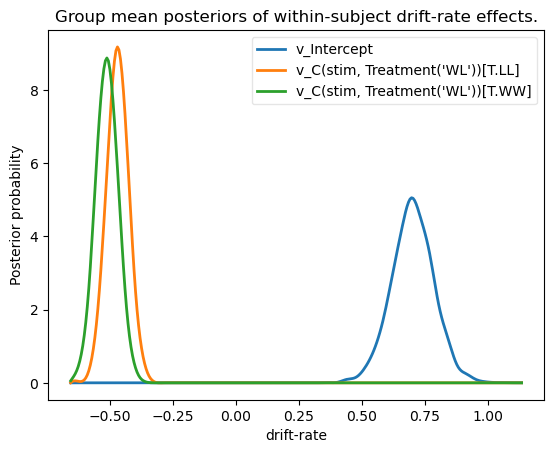

In [31]:
v_WL, v_LL, v_WW = m_reg_all.nodes_db.loc[["v_Intercept",
                                           "v_C(stim, Treatment('WL'))[T.LL]",
                                           "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [32]:
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'})
m_reg.sample(5000, burn=1000)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------100%-----------------] 5000 of 5000 complete in 974.8 sec

P(a_theta < 0) =  0.052


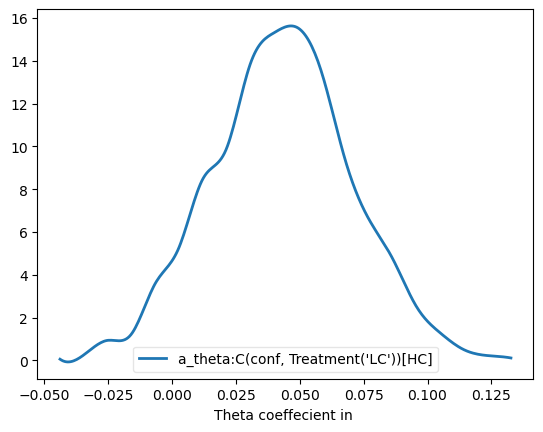

In [33]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [34]:
m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
                               "a ~ theta:C(conf, Treatment('LC'))",
                               depends_on={'v': 'stim'})
m_reg_off.sample(5000, burn=1000)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]


/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:148: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for uniq_elem, grouped_data in grouped:
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a futur

/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.nodes_db = pd.concat([self.nodes_db, row])
/opt/conda/lib/python3.8/site-packages/kabuki/hierarchical.py:134: FutureWarning: In a future version, object-dtype columns with a

 [-----------------100%-----------------] 5000 of 5000 complete in 964.9 sec

P(a_theta > 0) =  0.04575


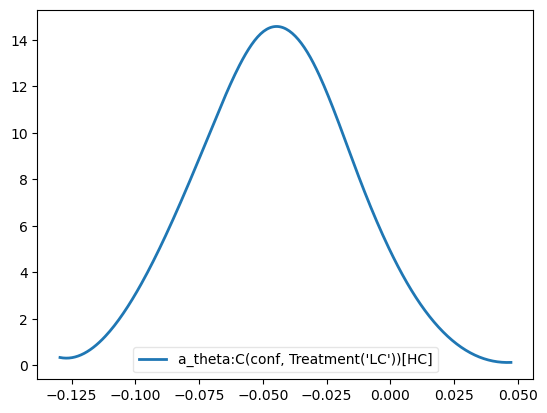

In [35]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing with outliers

This part of the tutorial seems outdated because, since 0.6.0, HDDM has a default setting `p_outliers=.05`. 

In [36]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

/opt/conda/lib/python3.8/site-packages/hddm/generate.py:683: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, 'rt'].iloc[:n_fast] = np.random.rand(
/opt/conda/lib/python3.8/site-packages/hddm/generate.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, 'rt'].iloc[n_fast:] = np.random.rand(


In [37]:
m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier.sample(2000, burn=50)

 [-----------------100%-----------------] 2000 of 2000 complete in 2.4 sec

Text(0, 0.5, 'Probability density')

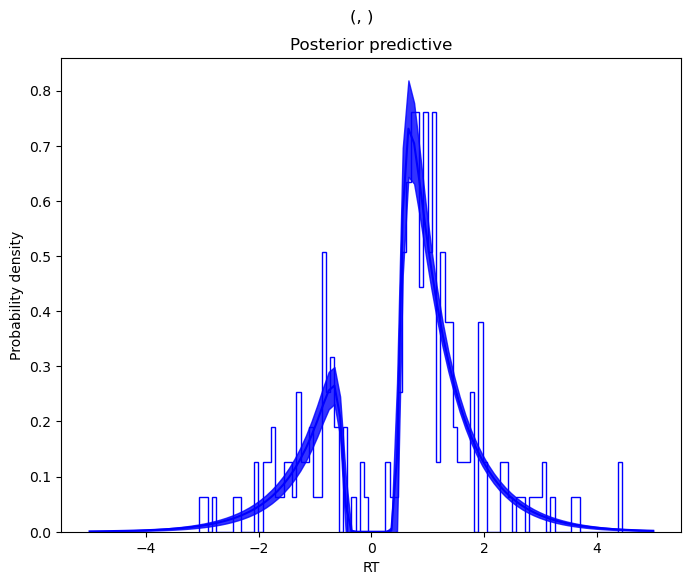

In [38]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_10.pdf')

In [39]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05)
m_outlier.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 2.4 sec

Text(0, 0.5, 'Probability density')

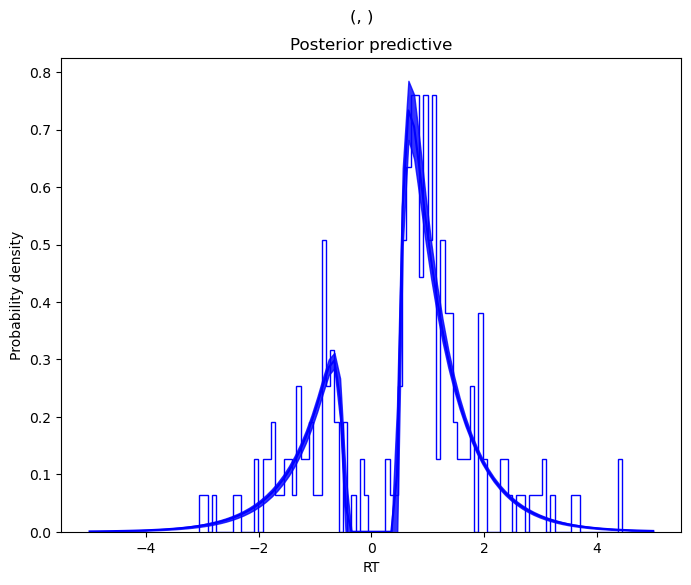

In [40]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_11.pdf')